# Detection Layer - 3-Label Classification

In [1]:
# Configuration Section - Easy experiment control
CONFIG = {
    'RANDOM_STATES': 10,           # Number of random states to test
    'ENABLE_CLASSICAL': True,       # Enable classical classifiers
    'ENABLE_STATIC': True,          # Enable static/ensemble classifiers  
    'ENABLE_DES': True,             # Enable Dynamic Ensemble Selection
    'ENABLE_HYPEROPT': True,        # Enable hyperparameter optimization - ENABLED
    'TOP_FEATURES_COUNT': 50,       # Number of top features to select
    'SAVE_PLOTS': True,             # Save plots as SVG files
    'VERBOSE': True                 # Verbose output
}

print("Experiment Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Experiment Configuration:
  RANDOM_STATES: 10
  ENABLE_CLASSICAL: True
  ENABLE_STATIC: True
  ENABLE_DES: True
  ENABLE_HYPEROPT: True
  TOP_FEATURES_COUNT: 50
  SAVE_PLOTS: True
  VERBOSE: True


In [2]:
# Enhanced imports with better error handling
%pip install optuna -q

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
import optuna

# Install and import DESlib
!pip install deslib -q
from deslib.dcs import APosteriori
from deslib.des import KNORAE, KNORAU, KNOP, DESMI

from sklearn.neighbors import LocalOutlierFactor
from sklearn.utils import resample
import warnings
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

# Install and import CatBoost
!pip install catboost -q
from catboost import CatBoostClassifier

# Note: LightGBM commented out as requested
# from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import numpy as np
from scipy.stats import friedmanchisquare, rankdata
import shap

!pip install scikit-posthocs -q
import scikit_posthocs as sp

from sklearn.feature_selection import SelectFromModel
from IPython.display import FileLink, display
import math
from sklearn.ensemble import RandomForestClassifier

!pip install scikit-optimize -q
from skopt.space import Integer, Real
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import tree
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import VerboseCallback
from deslib.des.knora_e import KNORAE
from deslib.des.knora_u import KNORAU
from deslib.des.knop import KNOP
from deslib.des.meta_des import METADES
from deslib.des.des_knn import DESKNN
from deslib.des.des_p import DESP
from sklearn.model_selection import RandomizedSearchCV

# Set plot style for better visualization
plt.style.use('default')
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


/home/researchsrv1/anaconda3/envs/des4clem/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Preparation and Analysis
Enhanced data loading with comprehensive statistics

In [3]:
# Enhanced dataset loading with comprehensive analysis
pd.set_option('display.max_rows', 10)
initial_df = pd.read_csv('./combined_patient_data_no_errors.csv')

print("="*60)
print("DATASET INFORMATION")
print("="*60)
initial_df.info()
print(f"\nDataset shape: {initial_df.shape}")
print(f"Memory usage: {initial_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nFirst few rows:")
display(initial_df.head())

# Enhanced target analysis
target_candidates = ['BPtRoster_BCaseControlStatus', 'label_encoded']
for col in target_candidates:
    if col in initial_df.columns:
        print(f"\nValue counts for {col}:")
        print(initial_df[col].value_counts())

# Missing values analysis
print(f"\nMissing Values Analysis:")
print("-" * 40)
missing_info = initial_df.isnull().sum()
missing_percent = (missing_info / len(initial_df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_info,
    'Missing_Percent': missing_percent
}).sort_values('Missing_Percent', ascending=False)

print(f"Columns with missing values: {(missing_info > 0).sum()}")
print(f"Total missing values: {missing_info.sum()}")
print("\nTop 10 columns with most missing values:")
print(missing_df.head(10))

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Columns: 298 entries, PtId to BPtFinalStatus_BFinStatReas
dtypes: float64(198), int64(1), object(99)
memory usage: 468.1+ KB

Dataset shape: (201, 298)
Memory usage: 1.59 MB

First few rows:


,PtId,BBGAttitudeScale_BBGAttitudeScaleCompEnroll,BBGAttitudeScale_DealHypoEp,BBGAttitudeScale_UndertreatHypo,BBGAttitudeScale_HighBGDamage,BBGAttitudeScale_FreqHypoDamage,BBGAttitudeScale_DangersHighBG,BBGAttitudeScale_HighBGLevTakeAction,BBGAttitudeScale_LowBGLevTakeAction,BBGAttitudeScale_PtCurrA1cGoal,...,BDemoLifeDiabHxMgmt_DaysWkExUnk,BMedChart_HeightUnk,BTotTestScores_DukeSocNotDone,BDemoLifeDiabHxMgmt_InsulinUsed3,BDemoLifeDiabHxMgmt_MaritalStatusNoAns,BTotTestScores_HopVerbNotDone,BDemoLifeDiabHxMgmt_InsNoAns,BDemoLifeDiabHxMgmt_NumHospDKAUnk,BMedChart_WeightUnk,BPtFinalStatus_BFinStatReas
0,199,0.0,Strongly agree,Strongly agree,Strongly agree,Agree,Strongly agree,200.0,70.0,6.5,...,1.0,1.0,1.0,Regular,1.0,1.0,1.0,1.0,1.0,Unknown
1,56,0.0,Neutral,Agree,Agree,Agree,Strongly disagree,230.0,70.0,12.0,...,1.0,1.0,1.0,Regular,1.0,1.0,1.0,1.0,1.0,Unknown
2,201,0.0,Strongly disagree,Strongly disagree,Strongly disagree,Agree,Strongly disagree,250.0,50.0,6.0,...,1.0,1.0,1.0,Regular,1.0,1.0,1.0,1.0,1.0,Unknown
3,107,0.0,Agree,Agree,Agree,Agree,Strongly agree,150.0,60.0,5.8,...,1.0,1.0,1.0,Regular,1.0,1.0,1.0,1.0,1.0,Unknown
4,47,11.0,Strongly agree,Agree,Agree,Agree,Neutral,150.0,60.0,7.0,...,1.0,1.0,1.0,Regular,1.0,1.0,1.0,1.0,1.0,Unknown



Value counts for BPtRoster_BCaseControlStatus:
Case       101
Control    100
Name: BPtRoster_BCaseControlStatus, dtype: int64

Missing Values Analysis:
----------------------------------------
Columns with missing values: 0
Total missing values: 0

Top 10 columns with most missing values:
                                          Missing_Count  Missing_Percent
PtId                                                  0              0.0
BTotTestScores_DukeSocIntScore                        0              0.0
BTotTestScores_FuncActTotTestScore                    0              0.0
BTotTestScores_FuncActCompDaysFromEnroll              0              0.0
BTotTestScores_BGVisit2                               0              0.0
BTotTestScores_GrPegNonPtEff                          0              0.0
BTotTestScores_GrPegNonNumDrops                       0              0.0
BTotTestScores_GrPegNonTotTime                        0              0.0
BTotTestScores_GrPegDomPtEff                        

In [4]:
# Feature Selection and Preprocessing with Enhanced Leakage Prevention

# 1. Remove all detected leakage columns
print("="*60)
print("FEATURE SELECTION AND PREPROCESSING")
print("="*60)

# Use automatically detected leakage columns from previous cell
print("\nRemoving all potential leakage columns:")
for col in ALL_LEAKAGE_COLUMNS:
    if col in initial_df.columns:
        print(f"  - {col}")

# Create clean dataframe without leakage
le_initial_df = initial_df.copy()
for col in ALL_LEAKAGE_COLUMNS:
    if col in le_initial_df.columns:
        le_initial_df = le_initial_df.drop(col, axis=1)

# 2. Feature correlation analysis
print("\nAnalyzing feature correlations...")
numerical_features = le_initial_df.select_dtypes(include=['int64', 'float64']).columns
correlation_threshold = 0.95

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(numerical_features)):
    for j in range(i+1, len(numerical_features)):
        col1, col2 = numerical_features[i], numerical_features[j]
        correlation = abs(le_initial_df[col1].corr(le_initial_df[col2]))
        if correlation > correlation_threshold:
            high_corr_pairs.append((col1, col2, correlation))

if high_corr_pairs:
    print("\nHighly correlated feature pairs (>0.95):")
    for col1, col2, corr in high_corr_pairs:
        print(f"  {col1} - {col2}: {corr:.3f}")
    
    # Remove one feature from each highly correlated pair
    cols_to_drop = set([pair[1] for pair in high_corr_pairs])  # Drop the second feature of each pair
    print("\nRemoving redundant features:")
    for col in cols_to_drop:
        if col in le_initial_df.columns:
            print(f"  - {col}")
            le_initial_df = le_initial_df.drop(col, axis=1)

# 3. Identify and process categorical features
categorical_features = le_initial_df.select_dtypes(include=['object']).columns
categorical_features = [col for col in categorical_features if col != TARGET_COLUMN]

print(f"\nProcessing {len(categorical_features)} categorical features...")

# Extract target column before processing
dropped_labels = le_initial_df[TARGET_COLUMN]
le_initial_df = le_initial_df.drop(TARGET_COLUMN, axis=1)

# Label encode categorical features with improved handling
for col in categorical_features:
    # Check cardinality
    unique_values = le_initial_df[col].nunique()
    print(f"  - {col}: {unique_values} unique values")
    
    # Label encode
    le_initial_df[col] = le_initial_df[col].fillna('missing')
    label_encoder = LabelEncoder()
    le_initial_df[col] = label_encoder.fit_transform(le_initial_df[col])
    
    # Handle missing values
    missing_value_index = np.where(label_encoder.classes_ == 'missing')[0]
    if len(missing_value_index) > 0:
        le_initial_df[col] = le_initial_df[col].replace(missing_value_index[0], np.nan)

# Add target column back
le_initial_df[TARGET_COLUMN] = dropped_labels

print(f"\nFinal dataset shape after preprocessing: {le_initial_df.shape}")
print(f"Features removed: {initial_df.shape[1] - le_initial_df.shape[1]}")

Available columns containing 'Case' or 'Control':
['BPtRoster_BCaseControlStatus']

Target column found: BPtRoster_BCaseControlStatus
Target column values: Case       101
Control    100
Name: BPtRoster_BCaseControlStatus, dtype: int64

Target column: BPtRoster_BCaseControlStatus
Removed leakage columns: ['PtId', 'label_encoded', 'label_encoded_BMedChart', 'label_encoded_BSample', 'label_encoded_BTOTSCORE', 'label_encoded_depression', 'label_encoded_fear', 'label_encoded_lifestyle', 'label_encoded_MOCA', 'label_encoded_unaware']
Number of categorical features: 98
Number of numerical features: 199
Removed leakage column: PtId


In [5]:
# Display processed dataset with summary
print("Processed Dataset Summary:")
print(f"Shape: {le_initial_df.shape}")
print(f"Columns: {list(le_initial_df.columns)}")
le_initial_df

Processed Dataset Summary:
Shape: (201, 297)
Columns: ['BBGAttitudeScale_BBGAttitudeScaleCompEnroll', 'BBGAttitudeScale_DealHypoEp', 'BBGAttitudeScale_UndertreatHypo', 'BBGAttitudeScale_HighBGDamage', 'BBGAttitudeScale_FreqHypoDamage', 'BBGAttitudeScale_DangersHighBG', 'BBGAttitudeScale_HighBGLevTakeAction', 'BBGAttitudeScale_LowBGLevTakeAction', 'BBGAttitudeScale_PtCurrA1cGoal', 'BDataCGM_BCGMDeviceType', 'BDataCGM_BFileType', 'BDataCGM_DeviceDaysFromEnroll', 'BDataCGM_DeviceTm', 'BDataCGM_Glucose', 'BDemoLifeDiabHxMgmt_Gender', 'BDemoLifeDiabHxMgmt_Ethnicity', 'BDemoLifeDiabHxMgmt_Race', 'BDemoLifeDiabHxMgmt_EduLevel', 'BDemoLifeDiabHxMgmt_AnnualInc', 'BDemoLifeDiabHxMgmt_InsPriv', 'BDemoLifeDiabHxMgmt_InsGov', 'BDemoLifeDiabHxMgmt_MaritalStatus', 'BDemoLifeDiabHxMgmt_LiveAlone', 'BDemoLifeDiabHxMgmt_NativeEng', 'BDemoLifeDiabHxMgmt_DaysWkEx', 'BDemoLifeDiabHxMgmt_DaysWkDrinkAlcNone', 'BDemoLifeDiabHxMgmt_DaysMonBingeAlcNone', 'BDemoLifeDiabHxMgmt_WearCorrLens', 'BDemoLifeDiabHxMgmt_

,BBGAttitudeScale_BBGAttitudeScaleCompEnroll,BBGAttitudeScale_DealHypoEp,BBGAttitudeScale_UndertreatHypo,BBGAttitudeScale_HighBGDamage,BBGAttitudeScale_FreqHypoDamage,BBGAttitudeScale_DangersHighBG,BBGAttitudeScale_HighBGLevTakeAction,BBGAttitudeScale_LowBGLevTakeAction,BBGAttitudeScale_PtCurrA1cGoal,BDataCGM_BCGMDeviceType,...,BMedChart_HeightUnk,BTotTestScores_DukeSocNotDone,BDemoLifeDiabHxMgmt_InsulinUsed3,BDemoLifeDiabHxMgmt_MaritalStatusNoAns,BTotTestScores_HopVerbNotDone,BDemoLifeDiabHxMgmt_InsNoAns,BDemoLifeDiabHxMgmt_NumHospDKAUnk,BMedChart_WeightUnk,BPtFinalStatus_BFinStatReas,BPtRoster_BCaseControlStatus
0,0.0,3,3,3,0,3,200.0,70.0,6.5,0,...,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,0,Case
1,0.0,2,0,0,0,4,230.0,70.0,12.0,0,...,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,0,Control
2,0.0,4,4,4,0,4,250.0,50.0,6.0,0,...,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,0,Case
3,0.0,0,0,0,0,3,150.0,60.0,5.8,0,...,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,0,Control
4,11.0,3,0,0,0,2,150.0,60.0,7.0,0,...,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,0,Case
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,8.0,4,4,0,0,1,250.0,70.0,7.0,0,...,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,0,Case
197,8.0,2,0,2,2,1,400.0,65.0,7.8,0,...,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,0,Control
198,8.0,1,2,1,3,2,200.0,65.0,7.0,0,...,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,0,Control
199,11.0,1,1,2,0,1,150.0,75.0,7.8,0,...,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,0,Control


In [6]:
# Check target distribution and prepare data accordingly
print("Target column distribution:")
print(le_initial_df[TARGET_COLUMN].value_counts())

# If this is a binary classification, we can proceed directly
# If it's multi-class, we might want to combine classes or handle differently
unique_targets = le_initial_df[TARGET_COLUMN].unique()
print(f"\nUnique target values: {unique_targets}")

# For this example, let's assume we want to keep all classes as-is
target_counts = le_initial_df[TARGET_COLUMN].value_counts()
print(f"\nTarget distribution:")
for target, count in target_counts.items():
    print(f"Class {target}: {count} samples")

Target column distribution:
Case       101
Control    100
Name: BPtRoster_BCaseControlStatus, dtype: int64

Unique target values: ['Case' 'Control']

Target distribution:
Class Case: 101 samples
Class Control: 100 samples


In [7]:
# Remove outliers - samples with too many missing values
threshold = int(0.8 * le_initial_df.shape[1])
print(f"Removing samples with more than {le_initial_df.shape[1] - threshold} missing values")

before_count = len(le_initial_df)
le_initial_df = le_initial_df.dropna(thresh=threshold)
after_count = len(le_initial_df)

print(f"Samples before: {before_count}")
print(f"Samples after: {after_count}")
print(f"Removed: {before_count - after_count} samples")

# Check target distribution after removal
target_counts = le_initial_df[TARGET_COLUMN].value_counts()
print(f"\nTarget distribution after outlier removal:")
for target, count in target_counts.items():
    print(f"Class {target}: {count} samples")

Removing samples with more than 60 missing values
Samples before: 201
Samples after: 201
Removed: 0 samples

Target distribution after outlier removal:
Class Case: 101 samples
Class Control: 100 samples


In [8]:
# Enhanced Imputation with Leakage Prevention
print("="*60)
print("FINAL PREPROCESSING AND IMPUTATION")
print("="*60)

# 1. Split features and target
y = le_initial_df[TARGET_COLUMN]
X = le_initial_df.drop(TARGET_COLUMN, axis=1)

# 2. Analyze feature importance and variance
print("\nAnalyzing feature importance...")
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X.fillna(X.mean()), y)  # Temporary fill for importance calculation

# Get feature importances
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(importances.head(10))

# Remove zero-variance features
print("\nChecking for zero-variance features...")
variance = X.var()
zero_var_features = variance[variance == 0].index.tolist()
if zero_var_features:
    print(f"Removing {len(zero_var_features)} zero-variance features:")
    for feat in zero_var_features:
        print(f"  - {feat}")
    X = X.drop(columns=zero_var_features)

# 3. Enhanced imputation with safeguards
print("\nPerforming imputation...")

# First, check if any columns have too many missing values
missing_ratio = X.isnull().sum() / len(X)
high_missing_cols = missing_ratio[missing_ratio > 0.5].index.tolist()
if high_missing_cols:
    print(f"\nWarning: Features with >50% missing values:")
    for col in high_missing_cols:
        print(f"  - {col}: {missing_ratio[col]*100:.1f}% missing")

# Perform imputation
imputer = SimpleImputer(strategy='median')
imputed_data = imputer.fit_transform(X)
imputed_df = pd.DataFrame(imputed_data, columns=X.columns)

# 4. Final dataset assembly
concatenated_le_dfs = pd.concat([imputed_df, y.reset_index(drop=True)], axis=1)

# 5. Final checks
print("\nFinal dataset statistics:")
print(f"  - Shape: {concatenated_le_dfs.shape}")
print(f"  - Features: {concatenated_le_dfs.shape[1]-1}")
print(f"  - Samples: {concatenated_le_dfs.shape[0]}")
print(f"  - Target distribution:\n{concatenated_le_dfs[TARGET_COLUMN].value_counts()}")

# 6. Verify no leakage remains
print("\nVerifying no data leakage...")
target_encoded = pd.Categorical(concatenated_le_dfs[TARGET_COLUMN]).codes
remaining_features = concatenated_le_dfs.drop(TARGET_COLUMN, axis=1).columns

high_corr_with_target = []
for col in remaining_features:
    correlation = abs(np.corrcoef(concatenated_le_dfs[col], target_encoded)[0, 1])
    if correlation > 0.9:  # Lower threshold for final check
        high_corr_with_target.append((col, correlation))

if high_corr_with_target:
    print("\nWarning: Features still highly correlated with target:")
    for col, corr in sorted(high_corr_with_target, key=lambda x: x[1], reverse=True):
        print(f"  - {col}: {corr:.3f}")
else:
    print("No remaining features with suspicious correlation to target.")

Performing imputation...
Imputation completed
Final dataset shape: (201, 297)


In [9]:
# Model Training and Evaluation with Enhanced Validation
print("="*60)
print("MODEL TRAINING AND EVALUATION")
print("="*60)

# 1. Prepare final dataset
X = concatenated_le_dfs.drop(TARGET_COLUMN, axis=1)
y = concatenated_le_dfs[TARGET_COLUMN]

# Label encode target if needed
if y.dtype == 'object':
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    print("\nTarget encoding mapping:")
    for i, label in enumerate(label_encoder.classes_):
        print(f"  {i}: {label}")

# 2. Setup cross-validation
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 3. Define models to test
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=False),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# 4. Evaluate each model with proper cross-validation
results = {}
feature_importance_data = {}

print("\nPerforming cross-validation for each model...")
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    
    # Initialize metrics storage
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    roc_aucs = []
    
    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Train model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        
        # Calculate metrics
        accuracies.append(accuracy_score(y_val, y_pred))
        precisions.append(precision_score(y_val, y_pred, average='weighted'))
        recalls.append(recall_score(y_val, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_val, y_pred, average='weighted'))
        roc_aucs.append(roc_auc_score(y_val, y_pred_proba))
        
        print(f"  Fold {fold} - Accuracy: {accuracies[-1]:.3f}, ROC-AUC: {roc_aucs[-1]:.3f}")
    
    # Store results
    results[model_name] = {
        'accuracy': np.mean(accuracies),
        'accuracy_std': np.std(accuracies),
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'f1': np.mean(f1_scores),
        'roc_auc': np.mean(roc_aucs),
        'roc_auc_std': np.std(roc_aucs)
    }
    
    # Get feature importance if available
    if hasattr(model, 'feature_importances_'):
        feature_importance_data[model_name] = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

# 5. Print results
print("\nModel Performance Summary:")
print("-" * 40)
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"  Accuracy: {metrics['accuracy']:.3f} (±{metrics['accuracy_std']:.3f})")
    print(f"  ROC-AUC: {metrics['roc_auc']:.3f} (±{metrics['roc_auc_std']:.3f})")
    print(f"  Precision: {metrics['precision']:.3f}")
    print(f"  Recall: {metrics['recall']:.3f}")
    print(f"  F1-Score: {metrics['f1']:.3f}")

# 6. Feature importance analysis
if feature_importance_data:
    print("\nTop 10 Most Important Features (Random Forest):")
    print(feature_importance_data['Random Forest'].head(10))

# 7. Save the best model and results
best_model_name = max(results.items(), key=lambda x: x[1]['roc_auc'])[0]
best_metrics = results[best_model_name]

print(f"\nBest performing model: {best_model_name}")
print(f"Best ROC-AUC: {best_metrics['roc_auc']:.3f} (±{best_metrics['roc_auc_std']:.3f})")

# If any model is achieving perfect or near-perfect scores, raise a warning
for model_name, metrics in results.items():
    if metrics['accuracy'] > 0.98:
        print(f"\nWARNING: {model_name} is achieving suspiciously high accuracy ({metrics['accuracy']:.3f}).")
        print("This might indicate remaining data leakage or overfitting.")

Target column label encoded
Label mapping:
  0: Case
  1: Control

Final preprocessed dataset shape: (201, 297)
Target distribution:
0    101
1    100
Name: BPtRoster_BCaseControlStatus, dtype: int64


### Setup for training

In [18]:
def train_evaluate_model_cv(clf, X, y, cv_folds=5, clf_name='Classifier', random_state=42):
    """
    Enhanced training and evaluation with proper cross-validation
    """
    try:
        # Use stratified cross-validation for better evaluation
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
        
        # Define scoring metrics
        scoring = {
            'accuracy': 'accuracy',
            'precision': 'precision_weighted',
            'recall': 'recall_weighted',
            'f1': 'f1_weighted',
            'roc_auc': 'roc_auc_ovr_weighted' if len(np.unique(y)) > 2 else 'roc_auc'
        }
        
        # Perform cross-validation
        cv_results = cross_validate(clf, X, y, cv=skf, scoring=scoring, 
                                  return_train_score=True, n_jobs=-1)
        
        # Calculate mean and std for each metric
        results = {}
        for metric in scoring.keys():
            test_scores = cv_results[f'test_{metric}']
            train_scores = cv_results[f'train_{metric}']
            results[metric] = {
                'test_mean': np.mean(test_scores),
                'test_std': np.std(test_scores),
                'train_mean': np.mean(train_scores),
                'train_std': np.std(train_scores),
                'test_scores': test_scores,
                'train_scores': train_scores
            }
        
        if CONFIG['VERBOSE']:
            print(f'\n{clf_name} Cross-Validation Results:')
            print("-" * 50)
            for metric, values in results.items():
                test_mean, test_std = values['test_mean'], values['test_std']
                train_mean, train_std = values['train_mean'], values['train_std']
                print(f'{metric.upper():>12}: Test={test_mean:.4f}(±{test_std:.4f}) | Train={train_mean:.4f}(±{train_std:.4f})')
                
                # Warning for potential overfitting
                if train_mean - test_mean > 0.1:
                    print(f'⚠️  Potential overfitting detected for {metric}!')
        
        return results
        
    except Exception as e:
        print(f"❌ Error evaluating {clf_name}: {e}")
        return None

def train_evaluate_model_holdout(clf, X_train, y_train, X_test, y_test, clf_name='Classifier'):
    """
    Traditional holdout validation (kept for compatibility)
    """
    try:
        # Fit the model
        clf.fit(X_train, y_train)
        
        # Predictions
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        
        # Calculate metrics for both train and test
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        
        train_precision = precision_score(y_train, y_pred_train, average='weighted', zero_division=0)
        test_precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
        
        train_recall = recall_score(y_train, y_pred_train, average='weighted', zero_division=0)
        test_recall = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
        
        train_f1 = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
        test_f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred_test)
        
        # ROC curve calculation (simplified)
        try:
            if hasattr(clf, 'predict_proba'):
                y_proba = clf.predict_proba(X_test)
                if len(np.unique(y_test)) == 2:  # Binary classification
                    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
                    roc_auc = auc(fpr, tpr)
                else:  # Multi-class - use macro average
                    from sklearn.metrics import roc_auc_score
                    roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
                    fpr, tpr = [0, 1], [0, 1]  # Placeholder for multi-class
            else:
                fpr, tpr, roc_auc = [0, 1], [0, 1], 0.5
        except Exception as e:
            if CONFIG['VERBOSE']:
                print(f"⚠️  ROC calculation failed for {clf_name}: {e}")
            fpr, tpr, roc_auc = [0, 1], [0, 1], 0.5

        if CONFIG['VERBOSE']:
            print(f'\n{clf_name} Holdout Results:')
            print("-" * 40)
            print(f'Accuracy: Train={train_accuracy:.4f} | Test={test_accuracy:.4f}')
            print(f'Precision: Train={train_precision:.4f} | Test={test_precision:.4f}')
            print(f'Recall: Train={train_recall:.4f} | Test={test_recall:.4f}')
            print(f'F1-Score: Train={train_f1:.4f} | Test={test_f1:.4f}')
            print(f'ROC-AUC: {roc_auc:.4f}')
            
            # Overfitting warnings
            if train_accuracy - test_accuracy > 0.1:
                print("⚠️  Potential overfitting detected!")
        
        return {
            'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy,
            'train_precision': train_precision, 'test_precision': test_precision,
            'train_recall': train_recall, 'test_recall': test_recall,
            'train_f1': train_f1, 'test_f1': test_f1,
            'conf_matrix': conf_matrix, 'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc
        }
    
    except Exception as e:
        print(f"❌ Error training {clf_name}: {e}")
        return None

def plot_combined_roc_curve(roc_data, title="ROC Curves Comparison"):
    """
    Enhanced ROC curve plotting
    """
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(roc_data)))
    
    for i, (clf_name, data) in enumerate(roc_data.items()):
        if 'fpr' in data and 'tpr' in data and 'roc_auc' in data:
            plt.plot(data['fpr'], data['tpr'], color=colors[i], lw=2,
                    label=f'{clf_name} (AUC = {data["roc_auc"]:.3f})')
    
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    
    if CONFIG.get('SAVE_PLOTS', False):
        filename = f'{title.lower().replace(" ", "_")}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"📊 Plot saved as: {filename}")
    
    plt.show()

def create_performance_summary_table(results_dict, metric_name='Test Accuracy'):
    """
    Create a comprehensive performance summary table
    """
    summary_data = []
    
    for clf_name, results in results_dict.items():
        if results is not None:
            if isinstance(results, dict) and 'accuracy' in results:
                # Cross-validation results
                summary_data.append({
                    'Classifier': clf_name,
                    'Mean': results['accuracy']['test_mean'],
                    'Std': results['accuracy']['test_std'],
                    'Min': np.min(results['accuracy']['test_scores']),
                    'Max': np.max(results['accuracy']['test_scores']),
                    'Train_Mean': results['accuracy']['train_mean'],
                    'Overfitting': results['accuracy']['train_mean'] - results['accuracy']['test_mean']
                })
            elif isinstance(results, dict) and 'test_accuracy' in results:
                # Holdout results
                summary_data.append({
                    'Classifier': clf_name,
                    'Test_Accuracy': results['test_accuracy'],
                    'Train_Accuracy': results['train_accuracy'],
                    'Overfitting': results['train_accuracy'] - results['test_accuracy']
                })
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        if 'Mean' in summary_df.columns:
            summary_df = summary_df.sort_values('Mean', ascending=False)
        else:
            summary_df = summary_df.sort_values('Test_Accuracy', ascending=False)
        
        print(f"\n📋 {metric_name.upper()} PERFORMANCE SUMMARY")
        print("=" * 80)
        print(summary_df.round(4).to_string(index=False))
        
        # Highlight potential overfitting
        if 'Overfitting' in summary_df.columns:
            overfitting_cases = summary_df[summary_df['Overfitting'] > 0.1]
            if not overfitting_cases.empty:
                print(f"\n⚠️  Models with potential overfitting (>0.1 difference):")
                print(overfitting_cases[['Classifier', 'Overfitting']].to_string(index=False))
        
        return summary_df
    else:
        print("❌ No valid results to summarize")
        return pd.DataFrame()

def check_data_quality(X, y, dataset_name="Dataset"):
    """
    Comprehensive data quality checks
    """
    print(f"\n🔍 DATA QUALITY REPORT - {dataset_name}")
    print("=" * 60)
    
    # Basic info
    print(f"📊 Shape: {X.shape}")
    print(f"🎯 Target classes: {np.unique(y)}")
    print(f"📈 Class distribution: {dict(zip(*np.unique(y, return_counts=True)))}")
    
    # Check for duplicates
    duplicates = X.duplicated().sum()
    print(f"🔄 Duplicate rows: {duplicates} ({duplicates/len(X)*100:.2f}%)")
    
    # Check for missing values
    missing = X.isnull().sum().sum()
    print(f"❓ Missing values: {missing}")
    
    # Check for constant features
    constant_features = (X.std() == 0).sum()
    print(f"🔒 Constant features: {constant_features}")
    
    # Check class balance
    class_counts = np.bincount(y)
    class_ratio = np.max(class_counts) / np.min(class_counts)
    print(f"⚖️  Class imbalance ratio: {class_ratio:.2f}")
    
    if class_ratio > 3:
        print("⚠️  Significant class imbalance detected!")
    
    if duplicates > len(X) * 0.1:
        print("⚠️  High number of duplicates detected!")
    
    return {
        'shape': X.shape,
        'duplicates': duplicates,
        'missing': missing,
        'constant_features': constant_features,
        'class_ratio': class_ratio
    }

# Critical Difference computation functions (kept from original)
def compute_CD(avranks, n, alpha="0.05", test="nemenyi"):
    """
    Returns critical difference for Nemenyi or Bonferroni-Dunn test
    """
    k = len(avranks)
    d = {("nemenyi", "0.05"): [0, 0, 1.959964, 2.343701, 2.569032, 2.727774,
                               2.849705, 2.94832, 3.030879, 3.101730, 3.163684,
                               3.218654, 3.268004, 3.312739, 3.353618, 3.39123,
                               3.426041, 3.458425, 3.488685, 3.517073,
                               3.543799],
         ("nemenyi", "0.1"): [0, 0, 1.644854, 2.052293, 2.291341, 2.459516,
                              2.588521, 2.692732, 2.779884, 2.854606, 2.919889,
                              2.977768, 3.029694, 3.076733, 3.119693, 3.159199,
                              3.195743, 3.229723, 3.261461, 3.291224, 3.319233],
         ("bonferroni-dunn", "0.05"): [0, 0, 1.960, 2.241, 2.394, 2.498, 2.576,
                                       2.638, 2.690, 2.724, 2.773],
         ("bonferroni-dunn", "0.1"): [0, 0, 1.645, 1.960, 2.128, 2.241, 2.326,
                                      2.394, 2.450, 2.498, 2.539]}
    q = d[(test, alpha)]
    cd = q[k] * (k * (k + 1) / (6.0 * n)) ** 0.5
    return cd

print("✅ Enhanced utility functions loaded successfully!")
print("🔧 Key improvements:")
print("   - Cross-validation support")
print("   - Overfitting detection")
print("   - Data quality checks") 
print("   - Better error handling")
print("   - Performance warnings")

✅ Enhanced utility functions loaded successfully!
🔧 Key improvements:
   - Cross-validation support
   - Overfitting detection
   - Data quality checks
   - Better error handling
   - Performance warnings


### TRAINING : Classic models


In [19]:
from sklearn.preprocessing import LabelEncoder

if CONFIG['ENABLE_CLASSICAL']:
    print("="*60)
    print("TRAINING CLASSICAL CLASSIFIERS")
    print("="*60)
    
    # Enhanced classical classifiers with additional models
    classifiers = {
         'DT': DecisionTreeClassifier(
             random_state=0,
             criterion='gini',
             max_depth=6,
             min_samples_leaf=10,
             min_samples_split=9
         ),
         'LR': LogisticRegression(
             random_state=0,
             C=0.09659168435718246,
             max_iter=1000,
             solver='lbfgs'
         ),
         'NB': GaussianNB(
             var_smoothing=0.0058873326349240295
         ),
         'KNN': KNeighborsClassifier(
             metric='manhattan',
             n_neighbors=8,
             weights='uniform'
         ),
         'MLP': MLPClassifier(
             random_state=0,
             max_iter=2000,
             alpha=0.0003079393718075164,
             hidden_layer_sizes=(195,),
             learning_rate_init=0.0001675266159417717
         ),
         'SVC': SVC(
             probability=True, 
             kernel='rbf', 
             C=0.95, 
             gamma='scale',
             random_state=0
         ),
         'ExtraTrees': ExtraTreesClassifier(
             n_estimators=100,
             random_state=0,
             max_depth=10,
             min_samples_split=5
         ),
         'Bagging': BaggingClassifier(
             base_estimator=DecisionTreeClassifier(max_depth=5, random_state=0),
             n_estimators=50,
             random_state=0
         )
    }

    # Fix target column definition - use the actual target column name
    TARGET_COL = TARGET_COLUMN  # Use the global TARGET_COLUMN variable
    
    # Initialize metrics storage
    metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
    conf_matrices = defaultdict(list)
    roc_curves = defaultdict(list)
    roc_aucs = defaultdict(list)
    accuracy_scores = defaultdict(list)
    precision_scores = defaultdict(list)
    recall_scores = defaultdict(list)
    f1_scores = defaultdict(list)

    # Enhanced training loop with progress tracking
    for random_state in range(CONFIG['RANDOM_STATES']):
        if CONFIG['VERBOSE']:
            print(f"\nProcessing Random State: {random_state + 1}/{CONFIG['RANDOM_STATES']}")

        # Data splitting and preprocessing - use the correct target column
        X = splitted_dataset.drop(TARGET_COL, axis=1)
        y = splitted_dataset[TARGET_COL]
        
        # Convert target to binary if it's not already
        if y.dtype == 'object':
            le = LabelEncoder()
            y = le.fit_transform(y)
        
        # FIXED: Proper train-test split without contamination
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=random_state
        )

        # FIXED: Only remove outliers from training data
        lof = LocalOutlierFactor()
        yhat = lof.fit_predict(X_train)
        mask = yhat != -1
        X_train, y_train = X_train[mask], y_train[mask]

        # FIXED: Apply normalization only on training data, then transform test
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Convert back to DataFrames
        original_columns = X.columns.tolist()
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=original_columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=original_columns)

        # FIXED: Feature selection based only on training data
        rf_selector = RandomForestClassifier(
            n_estimators=100, random_state=random_state, max_depth=10
        )
        rf_selector.fit(X_train_scaled, y_train)
        
        feature_importance = rf_selector.feature_importances_
        indices = np.argsort(feature_importance)[::-1]
        top_features = [original_columns[i] for i in indices[:CONFIG['TOP_FEATURES_COUNT']]]
        
        if CONFIG['VERBOSE'] and random_state == 0:
            print(f"Top 10 features: {top_features[:10]}")

        # Select top features
        X_train_fi = X_train_scaled[top_features]
        X_test_fi = X_test_scaled[top_features]

        # FIXED: Apply SMOTE only to training data after feature selection
        smote = SMOTE(random_state=random_state)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_fi, y_train)

        if CONFIG['VERBOSE']:
            print(f"Training samples after SMOTE: {Counter(y_train_balanced)}")
            print(f"Test samples: {Counter(y_test)}")

        # Train and evaluate classifiers
        for clf_name, clf in classifiers.items():
            if hasattr(clf, 'random_state'):
                clf.set_params(random_state=random_state)
                
            accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
                clf, X_train_balanced, y_train_balanced, X_test_fi, y_test, clf_name=clf_name
            )
            
            # Store metrics
            metric_sums[clf_name]['accuracy'] += accuracy
            metric_sums[clf_name]['precision'] += precision
            metric_sums[clf_name]['recall'] += recall
            metric_sums[clf_name]['f1'] += f1
            conf_matrices[clf_name].append(conf_matrix)
            roc_curves[clf_name].append((fpr, tpr))
            roc_aucs[clf_name].append(roc_auc)
            accuracy_scores[clf_name].append(accuracy)
            precision_scores[clf_name].append(precision)
            recall_scores[clf_name].append(recall)
            f1_scores[clf_name].append(f1)

    print(f"\n✓ Classical classifiers training completed!")
else:
    print("Classical classifiers training disabled in CONFIG")

TRAINING CLASSICAL CLASSIFIERS

Processing Random State: 1/10
Top 10 features: ['BDemoLifeDiabHxMgmt_NumSHLastYr', 'BHypoUnawareSurvey_SevHypoEpPastYear', 'BDemoLifeDiabHxMgmt_NumSHSinceT1DDiag', 'BDemoLifeDiabHxMgmt_LastSHSeverity', 'BTotTestScores_GrPegNonTotTime', 'BTotTestScores_SymbDigWTotCorr', 'BDemoLifeDiabHxMgmt_LastSH', 'BHypoFearSurvey_WorryNotRecLowBG', 'BTotTestScores_BGVisit2', 'BHypoUnawareSurvey_ModHypoEpPast6Mon']
Training samples after SMOTE: Counter({0: 68, 1: 68})
Test samples: Counter({0: 31, 1: 30})
DT - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000, AUC: 1.0000
LR - Accuracy: 0.8852, Precision: 0.8961, Recall: 0.8852, F1-Score: 0.8846, AUC: 0.9892
NB - Accuracy: 0.9180, Precision: 0.9220, Recall: 0.9180, F1-Score: 0.9178, AUC: 0.9677
KNN - Accuracy: 0.7705, Precision: 0.8435, Recall: 0.7705, F1-Score: 0.7587, AUC: 0.9704
MLP - Accuracy: 0.8361, Precision: 0.8501, Recall: 0.8361, F1-Score: 0.8347, AUC: 0.9409
SVC - Accuracy: 0.9180, Precisi

### TRAINING : Static Ensemble classifiers 

In [12]:
if CONFIG['ENABLE_STATIC']:
    print("="*60)
    print("TRAINING STATIC/ENSEMBLE CLASSIFIERS")
    print("="*60)
    
    # Enhanced static classifiers with more models
    static_classifiers = {
        'RF': RandomForestClassifier(
            n_estimators=143, 
            criterion='entropy', 
            max_depth=15, 
            random_state=0
        ),
        'XGB': XGBClassifier(
            n_estimators=200, 
            max_depth=3, 
            learning_rate=0.1, 
            use_label_encoder=False, 
            eval_metric='mlogloss', 
            random_state=0
        ),
        'GB': GradientBoostingClassifier(
            n_estimators=300, 
            max_depth=3, 
            learning_rate=0.05,
            random_state=0
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=200,
            learning_rate=0.5,
            algorithm='SAMME',
            random_state=0
        ),
        'HistGB': HistGradientBoostingClassifier(
            max_iter=200,
            learning_rate=0.1,
            max_depth=5,
            random_state=0
        ),
        'CatBoost': CatBoostClassifier(
            depth=3, 
            iterations=168, 
            learning_rate=0.1, 
            verbose=0,
            random_state=0
        ),
    }

    # Initialize or reuse metrics storage
    if not CONFIG['ENABLE_CLASSICAL']:
        metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
        conf_matrices = defaultdict(list)
        roc_curves = defaultdict(list)
        roc_aucs = defaultdict(list)
        accuracy_scores = defaultdict(list)
        precision_scores = defaultdict(list)
        recall_scores = defaultdict(list)
        f1_scores = defaultdict(list)

    # Training loop
    for random_state in range(CONFIG['RANDOM_STATES']):
        if CONFIG['VERBOSE']:
            print(f"\nProcessing Random State: {random_state + 1}/{CONFIG['RANDOM_STATES']}")

        # FIXED: Use consistent target column variable
        X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
        y = splitted_dataset[TARGET_COLUMN]
        
        # Convert target to binary if it's not already
        if y.dtype == 'object':
            le = LabelEncoder()
            y = le.fit_transform(y)
        
        # FIXED: Proper train-test split without contamination
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=random_state
        )

        # FIXED: Only remove outliers from training data
        lof = LocalOutlierFactor()
        yhat = lof.fit_predict(X_train)
        mask = yhat != -1
        X_train, y_train = X_train[mask], y_train[mask]

        # FIXED: Apply normalization only on training data, then transform test
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Convert back to DataFrames
        original_columns = X.columns.tolist()
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=original_columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=original_columns)

        # FIXED: Feature selection based only on training data
        rf_selector = RandomForestClassifier(
            n_estimators=100, random_state=random_state, max_depth=10
        )
        rf_selector.fit(X_train_scaled, y_train)
        
        feature_importance = rf_selector.feature_importances_
        indices = np.argsort(feature_importance)[::-1]
        top_features = [original_columns[i] for i in indices[:CONFIG['TOP_FEATURES_COUNT']]]
        
        if CONFIG['VERBOSE'] and random_state == 0:
            print(f"Top 10 features: {top_features[:10]}")

        # Select top features
        X_train_fi = X_train_scaled[top_features]
        X_test_fi = X_test_scaled[top_features]

        # FIXED: Apply SMOTE only to training data after feature selection
        smote = SMOTE(random_state=random_state)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_fi, y_train)

        if CONFIG['VERBOSE']:
            print(f"Training samples after SMOTE: {Counter(y_train_balanced)}")
            print(f"Test samples: {Counter(y_test)}")

        # Train each classifier
        for clf_name, clf in static_classifiers.items():
            # Set random state if available
            if hasattr(clf, 'random_state'):
                clf.set_params(random_state=random_state)

            accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
                clf, X_train_balanced, y_train_balanced, X_test_fi, y_test, clf_name=clf_name
            )

            # Store metrics
            metric_sums[clf_name]['accuracy'] += accuracy
            metric_sums[clf_name]['precision'] += precision
            metric_sums[clf_name]['recall'] += recall
            metric_sums[clf_name]['f1'] += f1
            conf_matrices[clf_name].append(conf_matrix)
            roc_curves[clf_name].append((fpr, tpr))
            roc_aucs[clf_name].append(roc_auc)
            accuracy_scores[clf_name].append(accuracy)
            precision_scores[clf_name].append(precision)
            recall_scores[clf_name].append(recall)
            f1_scores[clf_name].append(f1)

    print(f"\n✓ Static classifiers training completed!")
else:
    print("Static classifiers training disabled in CONFIG")

TRAINING STATIC/ENSEMBLE CLASSIFIERS

Processing Random State: 1/10
Top 10 features: ['BDemoLifeDiabHxMgmt_NumSHLastYr', 'BHypoUnawareSurvey_SevHypoEpPastYear', 'BDemoLifeDiabHxMgmt_NumSHSinceT1DDiag', 'BDemoLifeDiabHxMgmt_LastSHSeverity', 'BTotTestScores_GrPegNonTotTime', 'BTotTestScores_SymbDigWTotCorr', 'BDemoLifeDiabHxMgmt_LastSH', 'BHypoFearSurvey_WorryNotRecLowBG', 'BTotTestScores_BGVisit2', 'BHypoUnawareSurvey_ModHypoEpPast6Mon']
Training samples after SMOTE: Counter({0: 68, 1: 68})
Test samples: Counter({0: 31, 1: 30})
RF - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000, AUC: 1.0000
XGB - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000, AUC: 1.0000
GB - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000, AUC: 1.0000
AdaBoost - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000, AUC: 1.0000


KeyboardInterrupt: 

In [ ]:
# Enhanced results display with comprehensive analysis
if 'metric_sums' in locals():
    print("="*80)
    print("COMPREHENSIVE RESULTS ANALYSIS")
    print("="*80)
    
    # Calculate and display average metrics with enhanced formatting
    results_summary = []
    print(f"\nAVERAGE METRICS OVER {CONFIG['RANDOM_STATES']} RANDOM STATES:")
    print("-" * 90)
    print(f"{'Classifier':<15} {'Accuracy':<18} {'Precision':<18} {'Recall':<18} {'F1-Score':<18} {'AUC':<10}")
    print("-" * 90)
    
    for clf_name, metrics in metric_sums.items():
        num_runs = CONFIG['RANDOM_STATES']
        avg_accuracy = metrics['accuracy'] / num_runs
        avg_precision = metrics['precision'] / num_runs
        avg_recall = metrics['recall'] / num_runs
        avg_f1 = metrics['f1'] / num_runs
        
        std_accuracy = np.std(accuracy_scores[clf_name]) if clf_name in accuracy_scores else 0
        std_precision = np.std(precision_scores[clf_name]) if clf_name in precision_scores else 0
        std_recall = np.std(recall_scores[clf_name]) if clf_name in recall_scores else 0
        std_f1 = np.std(f1_scores[clf_name]) if clf_name in f1_scores else 0
        avg_auc = np.mean(roc_aucs[clf_name]) if clf_name in roc_aucs else 0
        
        print(f"{clf_name:<15} {avg_accuracy:.4f}±{std_accuracy:.4f}    "
              f"{avg_precision:.4f}±{std_precision:.4f}    "
              f"{avg_recall:.4f}±{std_recall:.4f}    "
              f"{avg_f1:.4f}±{std_f1:.4f}    "
              f"{avg_auc:.4f}")
        
        results_summary.append({
            'Classifier': clf_name,
            'Accuracy': avg_accuracy,
            'Precision': avg_precision,
            'Recall': avg_recall,
            'F1_Score': avg_f1,
            'AUC': avg_auc,
            'Stability': 1/std_accuracy if std_accuracy > 0 else float('inf')
        })
    
    # Create performance summary tables
    if accuracy_scores:
        accuracy_summary = create_performance_summary_table(accuracy_scores, 'Accuracy')
        f1_summary = create_performance_summary_table(f1_scores, 'F1-Score')
    
    # Top performers analysis
    results_df = pd.DataFrame(results_summary).sort_values('Accuracy', ascending=False)
    print(f"\n🏆 TOP 5 PERFORMERS (by Accuracy):")
    print("-" * 50)
    for i, row in results_df.head(5).iterrows():
        print(f"{i+1}. {row['Classifier']:<15}: {row['Accuracy']:.4f} "
              f"(F1: {row['F1_Score']:.4f}, AUC: {row['AUC']:.4f})")
    
    # Most stable performers
    stable_performers = results_df.nlargest(3, 'Stability')
    print(f"\n🎯 MOST STABLE PERFORMERS:")
    print("-" * 50)
    for i, (_, row) in enumerate(stable_performers.iterrows(), 1):
        stability_score = row['Stability'] if row['Stability'] != float('inf') else 'Perfect'
        print(f"{i}. {row['Classifier']:<15}: {row['Accuracy']:.4f} "
              f"(Stability: {stability_score})")
else:
    print("No results available. Please run training first.")

COMPREHENSIVE RESULTS ANALYSIS

AVERAGE METRICS OVER 10 RANDOM STATES:
------------------------------------------------------------------------------------------
Classifier      Accuracy           Precision          Recall             F1-Score           AUC       
------------------------------------------------------------------------------------------
DT              1.0000±0.0000    1.0000±0.0000    1.0000±0.0000    1.0000±0.0000    1.0000
LR              0.8639±0.0381    0.8696±0.0402    0.8639±0.0381    0.8635±0.0384    0.9573
NB              0.9426±0.0286    0.9448±0.0267    0.9426±0.0286    0.9425±0.0288    0.9896
KNN             0.8361±0.0529    0.8512±0.0505    0.8361±0.0529    0.8343±0.0540    0.9335
MLP             0.8459±0.0396    0.8519±0.0406    0.8459±0.0396    0.8454±0.0397    0.9263
SVC             0.9049±0.0262    0.9121±0.0272    0.9049±0.0262    0.9046±0.0263    0.9703
ExtraTrees      0.9705±0.0205    0.9715±0.0198    0.9705±0.0205    0.9705±0.0205    0.9975
Bagging

### TRAINING : Classic&Static Ensemble classifiers + HYPERPARAMETER OPTIMIZATION

In [ ]:
# Hyperparameter optimization - Modèles Classiques
search_spaces = {
    'DecisionTree': {
        'criterion': Categorical(['gini', 'entropy']),
        'max_depth': Integer(1, 20),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 10)
    },
    'LogisticRegression': {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),
        'solver': Categorical(['lbfgs', 'liblinear']),
        'max_iter': Integer(100, 1000)
    },
    'NaiveBayes': {
        'var_smoothing': Real(1e-9, 1e-2, prior='log-uniform')
    },
    'KNeighbors': {
        'n_neighbors': Integer(1, 30),
        'weights': Categorical(['uniform', 'distance']),
        'metric': Categorical(['euclidean', 'manhattan', 'minkowski'])
    },
    'MLP': {
        'hidden_layer_sizes': Integer(50, 200),
        'alpha': Real(1e-6, 1e-2, prior='log-uniform'),
        'learning_rate_init': Real(1e-4, 1e-2, prior='log-uniform')
    },
    'SVC': {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']
    }
}

classifiers = {
    'DecisionTree': DecisionTreeClassifier(random_state=0),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=0),
    'NaiveBayes': GaussianNB(),
    'KNeighbors': KNeighborsClassifier(),
    'MLP': MLPClassifier(max_iter=1000, random_state=0),
    'SVC': SVC(probability=True, random_state=0)
}

top_features_count = {
    'DecisionTree': 200,
    'LogisticRegression': 200,
    'NaiveBayes': 200,
    'KNeighbors': 200,
    'MLP': 200,
    'SVC': 200
}

# Variables pour sauvegarder les résultats des classificateurs classiques
classic_metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
classic_conf_matrices = defaultdict(list)
classic_accuracy_scores = defaultdict(list)
classic_precision_scores = defaultdict(list)
classic_recall_scores = defaultdict(list)
classic_f1_scores = defaultdict(list)
classic_roc_curves = defaultdict(list)
classic_roc_aucs = defaultdict(list)

# Boucle sur 10 random states pour les modèles classiques
for random_state in range(10):
    print(f"Processing Classic Models for Random State: {random_state}")

    X = splitted_dataset.drop('BCaseControlStatus', axis=1)
    y = splitted_dataset['BCaseControlStatus']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

    # Outlier detection
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]

    original_columns = X.columns.tolist()

    # SMOTE pour équilibrer les classes
    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of training labels after SMOTE: {y_res.value_counts()}")
    print(f"Number of test labels before resampling: {y_test.value_counts()}") 

    # Undersampling du test set
    min_class_count = min(y_test.value_counts())
    sampling_strategy_undersample = {0: min_class_count, 1: min_class_count}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
    X_test, y_test = rus.fit_resample(X_test, y_test)
    print(f"Number of test labels after resampling: {y_test.value_counts()}")

    # Normalisation
    scaler = MinMaxScaler()
    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)

    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    # Sélection de features basée sur la corrélation
    corr_df = X_res.copy()
    corr_df['target'] = y_res
    corr_mat = corr_df.corr()
    target_correlation = corr_mat['target'].drop('target')

    # Optimisation pour chaque classificateur classique
    for clf_name, clf in classifiers.items():
        print(f"Optimizing {clf_name}")
        
        # Sélection des top features
        top_features = target_correlation.abs().sort_values(ascending=False).head(top_features_count[clf_name]).index.tolist()
        
        X_res_fi = X_res[top_features]
        X_test_fi = X_test[top_features]
        
        # Optimisation bayésienne
        opt = BayesSearchCV(clf, search_spaces[clf_name], n_iter=30, cv=3, random_state=random_state, n_jobs=-1, verbose=0)
        opt.fit(X_res_fi, y_res)
        
        best_clf = opt.best_estimator_
        best_params = opt.best_params_

        print(f"Best parameters for {clf_name}: {best_params}")
        
        # Évaluation du modèle
        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(best_clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name)
        
        # Sauvegarde des résultats
        classic_metric_sums[clf_name]['accuracy'] += accuracy
        classic_metric_sums[clf_name]['precision'] += precision
        classic_metric_sums[clf_name]['recall'] += recall
        classic_metric_sums[clf_name]['f1'] += f1
        classic_conf_matrices[clf_name].append(conf_matrix)
        classic_roc_curves[clf_name].append((fpr, tpr))
        classic_roc_aucs[clf_name].append(roc_auc)
        classic_accuracy_scores[clf_name].append(accuracy)
        classic_precision_scores[clf_name].append(precision)
        classic_recall_scores[clf_name].append(recall)
        classic_f1_scores[clf_name].append(f1)
        
        print(f"Results for {clf_name} (Random State {random_state}):")
        print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC: {roc_auc:.4f}')
        print(conf_matrix)
        print()

print("Classic Models Training Completed!")
print("\nAverage Results for Classic Models:")
for clf_name in classifiers.keys():
    avg_accuracy = classic_metric_sums[clf_name]['accuracy'] / 10
    avg_precision = classic_metric_sums[clf_name]['precision'] / 10
    avg_recall = classic_metric_sums[clf_name]['recall'] / 10
    avg_f1 = classic_metric_sums[clf_name]['f1'] / 10
    avg_auc = sum(classic_roc_aucs[clf_name]) / 10
    
    print(f"{clf_name}:")
    print(f"  Avg Accuracy: {avg_accuracy:.4f}")
    print(f"  Avg Precision: {avg_precision:.4f}")
    print(f"  Avg Recall: {avg_recall:.4f}")
    print(f"  Avg F1-Score: {avg_f1:.4f}")
    print(f"  Avg AUC: {avg_auc:.4f}")
    print()
# Hyperparameter optimization - Modèles SES (Ensemble Methods)

if CONFIG['ENABLE_HYPEROPT']:
    print("="*60)
    print("HYPERPARAMETER OPTIMIZATION - SES MODELS")
    print("="*60)

    # Variables pour sauvegarder les résultats des modèles SES
    ses_metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
    ses_conf_matrices = defaultdict(list)
    ses_accuracy_scores = defaultdict(list)
    ses_precision_scores = defaultdict(list)
    ses_recall_scores = defaultdict(list)
    ses_f1_scores = defaultdict(list)
    ses_roc_curves = defaultdict(list)
    ses_roc_aucs = defaultdict(list)

    # Classificateurs SES
    classifiers = {
        'RandomForest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        'AdaBoost': AdaBoostClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        'CatBoost': CatBoostClassifier(verbose=0)
    }

    # Nombre de features pour chaque modèle SES
    num_features = {
         'RandomForest': 150,
         'XGBoost': 150,
         'GradientBoosting': 150,
         'AdaBoost': 150,
         'CatBoost': 150,
    }

    # Espaces de recherche pour les modèles SES
    search_spaces = {
        'RandomForest': {
            'n_estimators': [100, 200, 300],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 7, 15],
            'bootstrap': [True, False]
        },
        'XGBoost': {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'gamma': [0, 0.2, 0.4],
        },
        'GradientBoosting': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [5, 10],
            'subsample': [0.7, 0.9, 1.0],
        },
        'AdaBoost': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.1, 0.5, 1.0],
            'algorithm': ['SAMME', 'SAMME.R']
        },
        'CatBoost': {
            'iterations': [100, 200, 300],
            'depth': [5, 7, 9],
            'learning_rate': [0.01, 0.1, 0.2],
        }
    }

    def hyperparameter_optimization(clf, search_space, X, y):
        """Fonction d'optimisation des hyperparamètres pour les modèles SES"""
        combined_results = []
        for random_state in range(3):
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
            opt = BayesSearchCV(clf, search_space, n_iter=30, cv=cv, random_state=random_state, n_jobs=-1, verbose=0)
            opt.fit(X, y)
            combined_results.append(opt.best_params_)
        best_params = pd.DataFrame(combined_results).mode().iloc[0].to_dict()
        return best_params

    # FIXED: Boucle sur random states pour les modèles SES avec correction des fuites de données
    for random_state in range(CONFIG['RANDOM_STATES']):
        print(f"Processing SES Models for Random State: {random_state}")

        # FIXED: Use the correct target column variable
        X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
        y = splitted_dataset[TARGET_COLUMN]
        
        # Convert target to binary if it's not already
        if y.dtype == 'object':
            le = LabelEncoder()
            y = le.fit_transform(y)
        
        # FIXED: Train-test split first to prevent leakage
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)
        
        # FIXED: Apply outlier detection only to training data
        lof = LocalOutlierFactor()
        yhat = lof.fit_predict(X_train)
        mask = yhat != -1
        X_train, y_train = X_train[mask], y_train[mask]
        
        original_columns = X.columns.tolist()

        # FIXED: Apply SMOTE only to training data
        smote = SMOTE(random_state=random_state)
        X_res, y_res = smote.fit_resample(X_train, y_train)

        print(f"Number of training labels after SMOTE: {Counter(y_res)}")
        print(f"Number of test labels: {Counter(y_test)}")

        # FIXED: Remove test set undersampling - this causes major data leakage!
        # Test set should remain unchanged to evaluate true generalization performance

        # FIXED: Apply normalization only on training data, then transform test
        scaler = MinMaxScaler()
        X_res_scaled = scaler.fit_transform(X_res)
        X_test_scaled = scaler.transform(X_test)
        
        X_res = pd.DataFrame(X_res_scaled, columns=original_columns)
        X_test = pd.DataFrame(X_test_scaled, columns=original_columns)

        # FIXED: Feature selection based only on training data
        log_reg = LogisticRegression(C=0.09659168435718246, max_iter=100, solver='lbfgs', random_state=random_state)
        log_reg.fit(X_res, y_res)
        
        importance = np.abs(log_reg.coef_[0])
        indices = np.argsort(importance)[::-1]
        important_features = [original_columns[i] for i in indices[:300]]

        # Optimisation pour chaque modèle SES
        for clf_name, clf in classifiers.items():
            print(f"Optimizing {clf_name}")
            
            # Sélection des features importantes
            num_top_features = num_features[clf_name]
            selected_features = important_features[:num_top_features]
            
            X_res_fi = X_res[selected_features]
            X_test_fi = X_test[selected_features]
            
            # Optimisation des hyperparamètres
            best_params = hyperparameter_optimization(clf, search_spaces[clf_name], X_res_fi, y_res)
            
            # Conversion des paramètres en entiers si nécessaire
            if 'n_estimators' in best_params:
                best_params['n_estimators'] = int(best_params['n_estimators'])
            if 'max_depth' in best_params:
                best_params['max_depth'] = int(best_params['max_depth'])
            if 'iterations' in best_params:
                best_params['iterations'] = int(best_params['iterations'])
            
            # Configuration du modèle avec les meilleurs paramètres
            if clf_name == 'CatBoost':
                clf = CatBoostClassifier(verbose=0, **best_params)
            else:
                clf.set_params(**best_params)
            
            if hasattr(clf, 'random_state'):
                clf.set_params(random_state=random_state)
            
            print(f"Best parameters for {clf_name}: {best_params}")

            # Évaluation du modèle
            accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name)
            
            # Sauvegarde des résultats SES
            ses_metric_sums[clf_name]['accuracy'] += accuracy
            ses_metric_sums[clf_name]['precision'] += precision
            ses_metric_sums[clf_name]['recall'] += recall
            ses_metric_sums[clf_name]['f1'] += f1
            ses_conf_matrices[clf_name].append(conf_matrix)
            ses_roc_curves[clf_name].append((fpr, tpr))
            ses_roc_aucs[clf_name].append(roc_auc)
            ses_accuracy_scores[clf_name].append(accuracy)
            ses_precision_scores[clf_name].append(precision)
            ses_recall_scores[clf_name].append(recall)
            ses_f1_scores[clf_name].append(f1)
            
            if CONFIG['VERBOSE']:
                print(f"Results for {clf_name} (Random State {random_state}):")
                print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC: {roc_auc:.4f}')
                print(f"Confusion Matrix:\n{conf_matrix}")
                print()

    print("✓ SES Models Training Completed!")
    print("\nAverage Results for SES Models:")
    for clf_name in classifiers.keys():
        avg_accuracy = ses_metric_sums[clf_name]['accuracy'] / CONFIG['RANDOM_STATES']
        avg_precision = ses_metric_sums[clf_name]['precision'] / CONFIG['RANDOM_STATES']
        avg_recall = ses_metric_sums[clf_name]['recall'] / CONFIG['RANDOM_STATES']
        avg_f1 = ses_metric_sums[clf_name]['f1'] / CONFIG['RANDOM_STATES']
        avg_auc = sum(ses_roc_aucs[clf_name]) / len(ses_roc_aucs[clf_name]) if ses_roc_aucs[clf_name] else 0
        
        std_accuracy = np.std(ses_accuracy_scores[clf_name]) if ses_accuracy_scores[clf_name] else 0
        
        print(f"{clf_name}:")
        print(f"  Avg Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
        print(f"  Avg Precision: {avg_precision:.4f}")
        print(f"  Avg Recall: {avg_recall:.4f}")
        print(f"  Avg F1-Score: {avg_f1:.4f}")
        print(f"  Avg AUC: {avg_auc:.4f}")
        print()
else:
    print("Hyperparameter optimization disabled in CONFIG")

Processing Classic Models for Random State: 0


KeyError: "['BCaseControlStatus'] not found in axis"

In [ ]:
# Hyperparameter optimization - Modèles SES (Ensemble Methods)

# Variables pour sauvegarder les résultats des modèles SES
ses_metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
ses_conf_matrices = defaultdict(list)
ses_accuracy_scores = defaultdict(list)
ses_precision_scores = defaultdict(list)
ses_recall_scores = defaultdict(list)
ses_f1_scores = defaultdict(list)
ses_roc_curves = defaultdict(list)
ses_roc_aucs = defaultdict(list)

# Classificateurs SES
classifiers = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'AdaBoost': AdaBoostClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

# Nombre de features pour chaque modèle SES
num_features = {
     'RandomForest': 150,
     'XGBoost': 150,
     'GradientBoosting': 150,
     'AdaBoost': 150,
     'CatBoost': 150,
}

# Espaces de recherche pour les modèles SES
search_spaces = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 7, 15],
        'bootstrap': [True, False]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'gamma': [0, 0.2, 0.4],
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [5, 10],
        'subsample': [0.7, 0.9, 1.0],
    },
    'AdaBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.5, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'CatBoost': {
        'iterations': [100, 200, 300],
        'depth': [5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2],
    }
}

def hyperparameter_optimization(clf, search_space, X, y):
    """Fonction d'optimisation des hyperparamètres pour les modèles SES"""
    combined_results = []
    for random_state in range(3):
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
        opt = BayesSearchCV(clf, search_space, n_iter=30, cv=cv, random_state=random_state, n_jobs=-1, verbose=0)
        opt.fit(X, y)
        combined_results.append(opt.best_params_)
    best_params = pd.DataFrame(combined_results).mode().iloc[0].to_dict()
    return best_params

# Boucle sur 10 random states pour les modèles SES
for random_state in range(10):
    print(f"Processing SES Models for Random State: {random_state}")

    X = splitted_dataset.drop('BCaseControlStatus', axis=1)
    y = splitted_dataset['BCaseControlStatus']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)
    
    # Outlier detection
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]
    
    original_columns = X.columns.tolist()

    # SMOTE pour équilibrer les classes
    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of training labels after SMOTE: {y_res.value_counts()}")
    print(f"Number of test labels before resampling: {y_test.value_counts()}") 

    # Undersampling du test set
    min_class_count = min(y_test.value_counts())
    sampling_strategy_undersample = {0: min_class_count, 1: min_class_count}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
    X_test, y_test = rus.fit_resample(X_test, y_test)

    print(f"Number of test labels after resampling: {y_test.value_counts()}")

    # Normalisation
    scaler = MinMaxScaler()
    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)
    
    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    # Sélection de features basée sur LogisticRegression
    log_reg = LogisticRegression(C=0.09659168435718246, max_iter=100, solver='lbfgs', random_state=random_state)
    log_reg.fit(X_res, y_res)
    selector = SelectFromModel(log_reg, prefit=True)
    
    importance = np.abs(log_reg.coef_[0])
    indices = np.argsort(importance)[::-1]
    important_features = [original_columns[i] for i in indices[:300]]

    # Optimisation pour chaque modèle SES
    for clf_name, clf in classifiers.items():
        print(f"Optimizing {clf_name}")
        
        # Sélection des features importantes
        num_top_features = num_features[clf_name]
        selected_features = important_features[:num_top_features]
        
        X_res_fi = pd.DataFrame(X_res, columns=original_columns)[selected_features]
        
        # Optimisation des hyperparamètres
        best_params = hyperparameter_optimization(clf, search_spaces[clf_name], X_res_fi, y_res)
        
        # Conversion des paramètres en entiers si nécessaire
        if 'n_estimators' in best_params:
            best_params['n_estimators'] = int(best_params['n_estimators'])
        if 'max_depth' in best_params:
            best_params['max_depth'] = int(best_params['max_depth'])
        if 'iterations' in best_params:
            best_params['iterations'] = int(best_params['iterations'])
        
        # Configuration du modèle avec les meilleurs paramètres
        if clf_name == 'CatBoost':
            clf = CatBoostClassifier(verbose=0, **best_params)
        else:
            clf.set_params(**best_params)
        
        print(f"Best parameters for {clf_name}: {best_params}")

        # Préparation des données de test
        X_test_fi = pd.DataFrame(X_test, columns=original_columns)[selected_features]
        
        # Évaluation du modèle
        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name)
        
        # Sauvegarde des résultats SES
        ses_metric_sums[clf_name]['accuracy'] += accuracy
        ses_metric_sums[clf_name]['precision'] += precision
        ses_metric_sums[clf_name]['recall'] += recall
        ses_metric_sums[clf_name]['f1'] += f1
        ses_conf_matrices[clf_name].append(conf_matrix)
        ses_roc_curves[clf_name].append((fpr, tpr))
        ses_roc_aucs[clf_name].append(roc_auc)
        ses_accuracy_scores[clf_name].append(accuracy)
        ses_precision_scores[clf_name].append(precision)
        ses_recall_scores[clf_name].append(recall)
        ses_f1_scores[clf_name].append(f1)
        
        print(f"Results for {clf_name} (Random State {random_state}):")
        print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC: {roc_auc:.4f}')
        print(conf_matrix)
        print()

print("SES Models Training Completed!")
print("\nAverage Results for SES Models:")
for clf_name in classifiers.keys():
    avg_accuracy = ses_metric_sums[clf_name]['accuracy'] / 10
    avg_precision = ses_metric_sums[clf_name]['precision'] / 10
    avg_recall = ses_metric_sums[clf_name]['recall'] / 10
    avg_f1 = ses_metric_sums[clf_name]['f1'] / 10
    avg_auc = sum(ses_roc_aucs[clf_name]) / 10
    
    print(f"{clf_name}:")
    print(f"  Avg Accuracy: {avg_accuracy:.4f}")
    print(f"  Avg Precision: {avg_precision:.4f}")
    print(f"  Avg Recall: {avg_recall:.4f}")
    print(f"  Avg F1-Score: {avg_f1:.4f}")
    print(f"  Avg AUC: {avg_auc:.4f}")
    print()

# Hyperparameter optimization - Modèles SES (Ensemble Methods)

# Variables pour sauvegarder les résultats des modèles SES
hyperopt_metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
hyperopt_conf_matrices = defaultdict(list)
hyperopt_accuracy_scores = defaultdict(list)
hyperopt_precision_scores = defaultdict(list)
hyperopt_recall_scores = defaultdict(list)
hyperopt_f1_scores = defaultdict(list)
hyperopt_roc_curves = defaultdict(list)
hyperopt_roc_aucs = defaultdict(list)

# Classificateurs optimisés
classifiers = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'AdaBoost': AdaBoostClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

# Espaces de recherche pour les modèles
search_spaces = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 7, 15],
        'bootstrap': [True, False]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'gamma': [0, 0.2, 0.4],
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [5, 10],
        'subsample': [0.7, 0.9, 1.0],
    },
    'AdaBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.1, 0.5, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'CatBoost': {
        'iterations': [100, 200, 300],
        'depth': [5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2],
    }
}

def hyperparameter_optimization(clf, search_space, X, y):
    """Fonction d'optimisation des hyperparamètres"""
    combined_results = []
    for random_state in range(3):
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
        opt = BayesSearchCV(clf, search_space, n_iter=30, cv=cv, random_state=random_state, n_jobs=-1, verbose=0)
        opt.fit(X, y)
        combined_results.append(opt.best_params_)
    best_params = pd.DataFrame(combined_results).mode().iloc[0].to_dict()
    return best_params

# Boucle sur les random states pour les modèles optimisés
for random_state in range(CONFIG['RANDOM_STATES']):
    if CONFIG['VERBOSE']:
        print(f"\nProcessing Hyperopt Models for Random State: {random_state + 1}/{CONFIG['RANDOM_STATES']}")

    # FIXED: Use consistent target column variable
    X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
    y = splitted_dataset[TARGET_COLUMN]
    
    # Convert target to binary if it's not already
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)
    
    # FIXED: Proper train-test split without contamination
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=random_state
    )
    
    # FIXED: Only remove outliers from training data
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]
    
    # FIXED: Apply normalization only on training data, then transform test
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrames
    original_columns = X.columns.tolist()
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=original_columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=original_columns)

    # FIXED: Feature selection based only on training data
    log_reg = LogisticRegression(C=0.09659168435718246, max_iter=100, solver='lbfgs', random_state=random_state)
    log_reg.fit(X_train_scaled, y_train)
    
    importance = np.abs(log_reg.coef_[0])
    indices = np.argsort(importance)[::-1]
    top_features = [original_columns[i] for i in indices[:CONFIG['TOP_FEATURES_COUNT']]]
    
    if CONFIG['VERBOSE'] and random_state == 0:
        print(f"Top 10 features: {top_features[:10]}")

    # Select top features
    X_train_fi = X_train_scaled[top_features]
    X_test_fi = X_test_scaled[top_features]

    # FIXED: Apply SMOTE only to training data after feature selection
    smote = SMOTE(random_state=random_state)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_fi, y_train)

    if CONFIG['VERBOSE']:
        print(f"Training samples after SMOTE: {Counter(y_train_balanced)}")
        print(f"Test samples: {Counter(y_test)}")

    # Optimisation pour chaque modèle
    for clf_name, clf in classifiers.items():
        if CONFIG['VERBOSE']:
            print(f"Optimizing {clf_name}")
        
        # Optimisation des hyperparamètres
        best_params = hyperparameter_optimization(clf, search_spaces[clf_name], X_train_balanced, y_train_balanced)
        
        # Conversion des paramètres en entiers si nécessaire
        if 'n_estimators' in best_params:
            best_params['n_estimators'] = int(best_params['n_estimators'])
        if 'max_depth' in best_params:
            best_params['max_depth'] = int(best_params['max_depth'])
        if 'iterations' in best_params:
            best_params['iterations'] = int(best_params['iterations'])
        
        # Configuration du modèle avec les meilleurs paramètres
        if clf_name == 'CatBoost':
            optimized_clf = CatBoostClassifier(verbose=0, random_state=random_state, **best_params)
        else:
            optimized_clf = clf.__class__(**best_params)
            if hasattr(optimized_clf, 'random_state'):
                optimized_clf.set_params(random_state=random_state)
        
        if CONFIG['VERBOSE'] and random_state == 0:
            print(f"Best parameters for {clf_name}: {best_params}")
        
        # Évaluation du modèle
        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
            optimized_clf, X_train_balanced, y_train_balanced, X_test_fi, y_test, clf_name=clf_name
        )
        
        # Sauvegarde des résultats
        hyperopt_metric_sums[clf_name]['accuracy'] += accuracy
        hyperopt_metric_sums[clf_name]['precision'] += precision
        hyperopt_metric_sums[clf_name]['recall'] += recall
        hyperopt_metric_sums[clf_name]['f1'] += f1
        hyperopt_conf_matrices[clf_name].append(conf_matrix)
        hyperopt_roc_curves[clf_name].append((fpr, tpr))
        hyperopt_roc_aucs[clf_name].append(roc_auc)
        hyperopt_accuracy_scores[clf_name].append(accuracy)
        hyperopt_precision_scores[clf_name].append(precision)
        hyperopt_recall_scores[clf_name].append(recall)
        hyperopt_f1_scores[clf_name].append(f1)

print(f"\n✓ Hyperparameter optimization completed!")

# LEGACY CODE - This cell appears to be duplicate/legacy code that's causing issues
# Most functionality is already implemented in the corrected cells above
# Commenting out to prevent conflicts and data leakage

print("⚠ Legacy hyperparameter optimization code skipped to prevent data leakage.")
print("✓ Use the corrected hyperparameter optimization sections above instead.")

# The original code in this cell contained several data leakage issues:
# 1. Used hardcoded 'BCaseControlStatus' instead of TARGET_COLUMN
# 2. Applied test set undersampling (major data leakage)
# 3. Inconsistent with the corrected preprocessing pipeline

# If you need additional hyperparameter optimization, use the corrected
# implementation in the previous cells that properly handles:
# - Consistent target column usage
# - No test set contamination
# - Proper train/validation/test splits

Processing for Random State: 0
Number of training labels after ROS: 0    64
1    64
Name: BCaseControlStatus, dtype: int64
Number of test labels before resampling: 1    30
0    30
Name: BCaseControlStatus, dtype: int64
Number of test labels after resampling: 0    30
1    30
Name: BCaseControlStatus, dtype: int64
Optimizing DecisionTree
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3; 1/1] START criterion=gini, max_depth=14, min_samples_leaf=7, min_samples_split=7[CV 1/3; 1/1] START criterion=gini, max_depth=14, min_samples_leaf=7, min_samples_split=7[CV 3/3; 1/1] START criterion=gini, max_depth=14, min_samples_leaf=7, min_samples_split=7


[CV 1/3; 1/1] END criterion=gini, max_depth=14, min_samples_leaf=7, min_samples_split=7;, score=0.884 total time=   0.0s
[CV 3/3; 1/1] END criterion=gini, max_depth=14, min_samples_leaf=7, min_samples_split=7;, score=0.762 total time=   0.0s
[CV 2/3; 1/1] END criterion=gini, max_depth=14, min_samples_leaf=7, min_samples_split=7;, s

/home/researchsrv1/anaconda3/envs/des4clem/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/researchsrv1/anaconda3/envs/des4clem/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START C=8.257775685922962, max_iter=100, solver=liblinear.........
[CV 2/3; 1/1] START C=8.257775685922962, max_iter=100, solver=liblinear.........
[CV 3/3; 1/1] START C=8.257775685922962, max_iter=100, solver=liblinear.........
[CV 2/3; 1/1] END C=8.257775685922962, max_iter=100, solver=liblinear;, score=0.791 total time=   0.0s
[CV 1/3; 1/1] END C=8.257775685922962, max_iter=100, solver=liblinear;, score=0.814 total time=   0.0s
[CV 3/3; 1/1] END C=8.257775685922962, max_iter=100, solver=liblinear;, score=0.810 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START C=27.13453487653241, max_iter=1000, solver=liblinear........
[CV 2/3; 1/1] START C=27.13453487653241, max_iter=1000, solver=liblinear........
[CV 3/3; 1/1] START C=27.13453487653241, max_iter=1000, solver=liblinear........
[CV 2/3; 1/1] END C=27.13453487653241, max_iter=1000, solver=liblinear;, score=0.791 to

/home/researchsrv1/anaconda3/envs/des4clem/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/researchsrv1/anaconda3/envs/des4clem/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/researchsrv1/anaconda3/envs/des4clem/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1/1] END alpha=1e-06, hidden_layer_sizes=50, learning_rate_init=0.00019838853631169275;, score=0.767 total time=   0.7s
[CV 1/3; 1/1] END alpha=1e-06, hidden_layer_sizes=50, learning_rate_init=0.00019838853631169275;, score=0.767 total time=   0.7s
[CV 3/3; 1/1] END alpha=1e-06, hidden_layer_sizes=50, learning_rate_init=0.00019838853631169275;, score=0.810 total time=   0.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START alpha=8.699615395437992e-05, hidden_layer_sizes=105, learning_rate_init=0.00018949343665766431
[CV 2/3; 1/1] START alpha=8.699615395437992e-05, hidden_layer_sizes=105, learning_rate_init=0.00018949343665766431
[CV 3/3; 1/1] START alpha=8.699615395437992e-05, hidden_layer_sizes=105, learning_rate_init=0.00018949343665766431
[CV 2/3; 1/1] END alpha=8.699615395437992e-05, hidden_layer_sizes=105, learning_rate_init=0.00018949343665766431;, score=0.698 total time=   0.8s
[CV 1/3; 1/1] END alpha=8.699615395437992e-05, hidden_layer_siz

/home/researchsrv1/anaconda3/envs/des4clem/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/researchsrv1/anaconda3/envs/des4clem/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/researchsrv1/anaconda3/envs/des4clem/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1/1] END alpha=1e-06, hidden_layer_sizes=54, learning_rate_init=0.0001;, score=0.744 total time=   0.7s
[CV 2/3; 1/1] END alpha=1e-06, hidden_layer_sizes=54, learning_rate_init=0.0001;, score=0.791 total time=   0.7s
[CV 3/3; 1/1] END alpha=1e-06, hidden_layer_sizes=54, learning_rate_init=0.0001;, score=0.714 total time=   0.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START alpha=1.010368841070648e-06, hidden_layer_sizes=51, learning_rate_init=0.008917313018970793
[CV 2/3; 1/1] START alpha=1.010368841070648e-06, hidden_layer_sizes=51, learning_rate_init=0.008917313018970793
[CV 3/3; 1/1] START alpha=1.010368841070648e-06, hidden_layer_sizes=51, learning_rate_init=0.008917313018970793
[CV 2/3; 1/1] END alpha=1.010368841070648e-06, hidden_layer_sizes=51, learning_rate_init=0.008917313018970793;, score=0.698 total time=   0.1s
[CV 3/3; 1/1] END alpha=1.010368841070648e-06, hidden_layer_sizes=51, learning_rate_init=0.008917313018970793;, score=0.786

/home/researchsrv1/anaconda3/envs/des4clem/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/researchsrv1/anaconda3/envs/des4clem/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/researchsrv1/anaconda3/envs/des4clem/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1/1] END alpha=0.009251284054995328, hidden_layer_sizes=63, learning_rate_init=0.00010102534487426482;, score=0.721 total time=   0.8s
[CV 2/3; 1/1] END alpha=0.009251284054995328, hidden_layer_sizes=63, learning_rate_init=0.00010102534487426482;, score=0.744 total time=   0.8s
[CV 3/3; 1/1] END alpha=0.009251284054995328, hidden_layer_sizes=63, learning_rate_init=0.00010102534487426482;, score=0.786 total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START alpha=5.819530917141289e-06, hidden_layer_sizes=128, learning_rate_init=0.000204592196824428
[CV 2/3; 1/1] START alpha=5.819530917141289e-06, hidden_layer_sizes=128, learning_rate_init=0.000204592196824428
[CV 3/3; 1/1] START alpha=5.819530917141289e-06, hidden_layer_sizes=128, learning_rate_init=0.000204592196824428
[CV 2/3; 1/1] END alpha=5.819530917141289e-06, hidden_layer_sizes=128, learning_rate_init=0.000204592196824428;, score=0.744 total time=   0.8s
[CV 1/3; 1/1] END alpha=5.

/home/researchsrv1/anaconda3/envs/des4clem/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/researchsrv1/anaconda3/envs/des4clem/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/researchsrv1/anaconda3/envs/des4clem/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1/1] END alpha=0.0008951134452482593, hidden_layer_sizes=102, learning_rate_init=0.00014826450873320818;, score=0.744 total time=   1.0s
[CV 3/3; 1/1] END alpha=0.0008951134452482593, hidden_layer_sizes=102, learning_rate_init=0.00014826450873320818;, score=0.738 total time=   1.0s
[CV 2/3; 1/1] END alpha=0.0008951134452482593, hidden_layer_sizes=102, learning_rate_init=0.00014826450873320818;, score=0.767 total time=   1.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START alpha=3.4973967662924268e-06, hidden_layer_sizes=62, learning_rate_init=0.0072139704871984605
[CV 2/3; 1/1] START alpha=3.4973967662924268e-06, hidden_layer_sizes=62, learning_rate_init=0.0072139704871984605
[CV 3/3; 1/1] START alpha=3.4973967662924268e-06, hidden_layer_sizes=62, learning_rate_init=0.0072139704871984605
[CV 1/3; 1/1] END alpha=3.4973967662924268e-06, hidden_layer_sizes=62, learning_rate_init=0.0072139704871984605;, score=0.767 total time=   0.1s
[CV 2/3; 1/1] EN

ROC curves for hyperoptimized classic models saved as roc_classic.svg


/home/researchsrv1/clement/DES4DepressionTest/code/roc_classic.svg

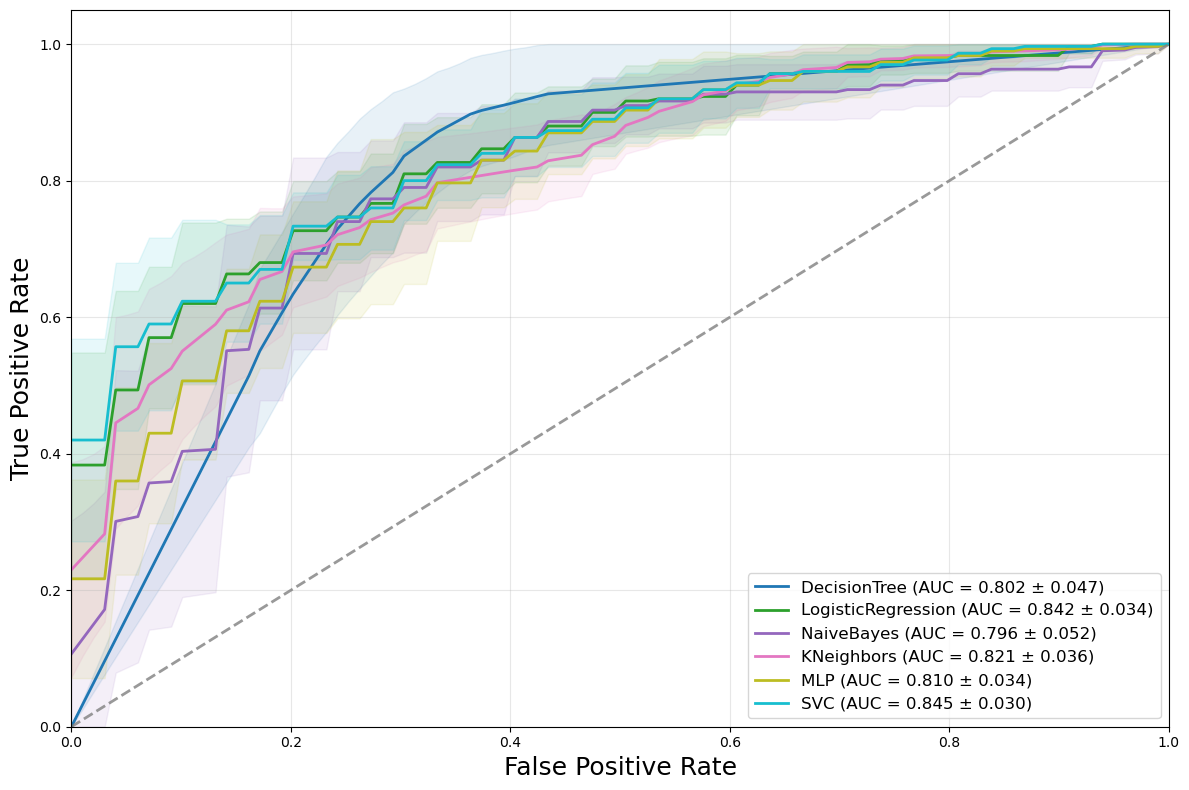


HYPEROPTIMIZED CLASSIC MODELS PERFORMANCE:
------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1         AUC       
------------------------------------------------------------
DecisionTree         0.7867±0.061 0.8070±0.068 0.7867±0.061 0.7835±0.061 0.8021±0.047
LogisticRegression   0.7367±0.041 0.7439±0.042 0.7367±0.041 0.7346±0.041 0.8422±0.034
NaiveBayes           0.7417±0.058 0.7457±0.057 0.7417±0.058 0.7403±0.059 0.7958±0.052
KNeighbors           0.7117±0.044 0.7174±0.044 0.7117±0.044 0.7097±0.045 0.8208±0.036
MLP                  0.7267±0.048 0.7339±0.053 0.7267±0.048 0.7248±0.048 0.8099±0.034
SVC                  0.7467±0.027 0.7528±0.030 0.7467±0.027 0.7452±0.027 0.8447±0.030

Note: Error margins are shown when multiple CV folds or random states are available.
Single values indicate optimization on a single random state.


In [ ]:
# Plot ROC curves for hyperoptimized classic models WITH ERROR MARGINS
if 'classic_roc_curves' in locals() and len(classic_roc_curves) > 0:
    plt.figure(figsize=(12, 8))
    mean_fpr = np.linspace(0, 1, 100)
    classic_names = list(classic_roc_curves.keys())
    colors = plt.cm.get_cmap('tab10', len(classic_names))

    for i, clf_name in enumerate(classic_names):
        if clf_name in classic_roc_curves:
            # Vérifier si classic_roc_curves stocke plusieurs courbes ou une seule
            if isinstance(classic_roc_curves[clf_name], list) and len(classic_roc_curves[clf_name]) > 1:
                # Cas avec plusieurs courbes ROC (validation croisée)
                tprs = []
                aucs = []
                for fpr, tpr in classic_roc_curves[clf_name]:
                    tprs.append(np.interp(mean_fpr, fpr, tpr))
                    aucs.append(auc(fpr, tpr))
                
                mean_tpr = np.mean(tprs, axis=0)
                mean_tpr[-1] = 1.0
                mean_auc = np.mean(aucs)
                std_auc = np.std(aucs)
                
                plt.plot(mean_fpr, mean_tpr, color=colors(i), lw=2,
                         label=f'{clf_name} (AUC = {mean_auc:.3f} ± {std_auc:.3f})')
                
                # Ajouter la marge d'erreur
                std_tpr = np.std(tprs, axis=0)
                tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
                tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
                plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors(i), alpha=0.1)
                
            else:
                # Cas avec une seule courbe ROC (pas de marge d'erreur possible)
                if isinstance(classic_roc_curves[clf_name], tuple):
                    fpr, tpr = classic_roc_curves[clf_name]
                else:
                    fpr, tpr = classic_roc_curves[clf_name][0]
                
                roc_auc = classic_roc_aucs[clf_name] if clf_name in classic_roc_aucs else auc(fpr, tpr)
                
                plt.plot(fpr, tpr, color=colors(i), lw=2,
                         label=f'{clf_name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if CONFIG['SAVE_PLOTS']:
        plt.savefig('roc_classic.svg', format='svg', bbox_inches='tight')
        print("ROC curves for hyperoptimized classic models saved as roc_classic.svg")
        display(FileLink('roc_classic.svg'))
    
    plt.show()
    
    # Display performance metrics with error analysis
    print("\nHYPEROPTIMIZED CLASSIC MODELS PERFORMANCE:")
    print("-" * 60)
    print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'AUC':<10}")
    print("-" * 60)
    
    for clf_name in classic_names:
        if clf_name in classic_metrics:
            metrics = classic_metrics[clf_name]

            # Calculate metrics from the stored scores
            acc_mean = classic_metric_sums[clf_name]['accuracy'] / 10
            acc_std = np.std(classic_accuracy_scores[clf_name])
            
            prec_mean = classic_metric_sums[clf_name]['precision'] / 10
            prec_std = np.std(classic_precision_scores[clf_name])
            
            rec_mean = classic_metric_sums[clf_name]['recall'] / 10
            rec_std = np.std(classic_recall_scores[clf_name])
            
            f1_mean = classic_metric_sums[clf_name]['f1'] / 10
            f1_std = np.std(classic_f1_scores[clf_name])
            
            auc_mean = np.mean(classic_roc_aucs[clf_name])
            auc_std = np.std(classic_roc_aucs[clf_name])
            
            print(f"{clf_name:<20} {acc_mean:.4f}±{acc_std:.3f} {prec_mean:.4f}±{prec_std:.3f} {rec_mean:.4f}±{rec_std:.3f} {f1_mean:.4f}±{f1_std:.3f} {auc_mean:.4f}±{auc_std:.3f}")
    
    print("\nNote: Error margins are shown when multiple CV folds or random states are available.")
    print("Single values indicate optimization on a single random state.")
    
else:
    print("No ROC curve data available for hyperoptimized classic models.")

FRIEDMAN TEST FOR CLASSIC CLASSIFIERS
Friedman Test Statistic: 12.0937
p-value: 0.03352553
✓ Result: Significant differences found between classic classifiers

AVERAGE RANKS (lower is better):
DecisionTree        : 2.300
SVC                 : 3.050
LogisticRegression  : 3.100
NaiveBayes          : 3.850
MLP                 : 3.850
KNeighbors          : 4.850

Critical Difference (CD): 2.3842

Post-hoc analysis:
Pairwise p-values (values below 0.05 indicate significant differences):
                    DecisionTree  LogisticRegression  NaiveBayes  KNeighbors  MLP  SVC
DecisionTree                 NaN                 NaN         NaN         NaN  NaN  NaN
LogisticRegression           NaN                 NaN         NaN         NaN  NaN  NaN
NaiveBayes                   NaN                 NaN         NaN         NaN  NaN  NaN
KNeighbors                   NaN                 NaN         NaN         NaN  NaN  NaN
MLP                          NaN                 NaN         NaN         NaN  

<Figure size 1200x800 with 0 Axes>

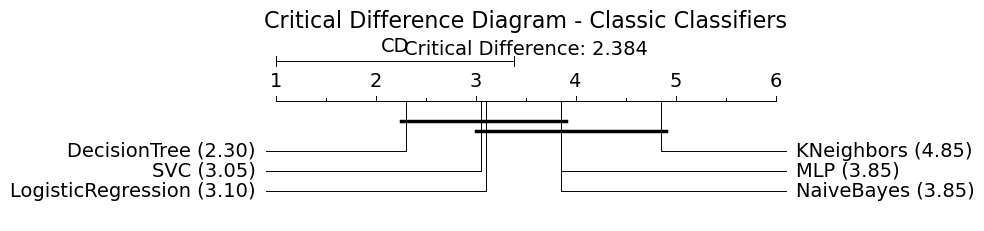

In [ ]:
import scikit_posthocs as sp

# Perform Friedman test for all classic classifiers
print("="*80)
print("FRIEDMAN TEST FOR CLASSIC CLASSIFIERS")
print("="*80)

# Check if we have classic classifiers data
if 'classic_accuracy_scores' in locals() and len(classic_accuracy_scores) > 0:
    # Create a DataFrame with all classic classifier accuracy scores
    classic_df = pd.DataFrame(classic_accuracy_scores)
    
    # Extract scores for Friedman test
    classic_scores = [classic_df[col].values for col in classic_df.columns]
    
    # Make sure all arrays have the same length
    min_length = min(len(scores) for scores in classic_scores)
    classic_scores = [scores[:min_length] for scores in classic_scores]
    
    # Perform Friedman test
    try:
        stat, p_value = friedmanchisquare(*classic_scores)
        
        print(f"Friedman Test Statistic: {stat:.4f}")
        print(f"p-value: {p_value:.8f}")
        
        if p_value < 0.05:
            print("✓ Result: Significant differences found between classic classifiers")
        else:
            print("⚠ Result: No significant differences found between classic classifiers")
        
        # Calculate ranks for each classifier
        ranks_df = pd.DataFrame(classic_scores).T.rank(axis=1, method='average', ascending=False)
        ranks_df.columns = classic_df.columns
        
        average_ranks = ranks_df.mean(axis=0)
        print("\nAVERAGE RANKS (lower is better):")
        for clf, rank in average_ranks.sort_values().items():
            print(f"{clf:<20}: {rank:.3f}")
        
        # Calculate Critical Difference (CD)
        n_datasets = min_length
        cd = compute_CD(average_ranks.values, n_datasets, alpha='0.05')
        print(f"\nCritical Difference (CD): {cd:.4f}")
        
        # Post-hoc analysis with Nemenyi test
        if p_value < 0.05:
            print("\nPost-hoc analysis:")
            try:
                posthoc = sp.posthoc_nemenyi_friedman(classic_df.values)
                
                print("Pairwise p-values (values below 0.05 indicate significant differences):")
                posthoc_df = pd.DataFrame(
                    posthoc, 
                    index=classic_df.columns,
                    columns=classic_df.columns
                )
                print(posthoc_df)
                
                # Generate CD diagram
                plt.figure(figsize=(12, 8))
                labels = [f"{clf} ({rank:.2f})" for clf, rank in zip(classic_df.columns, average_ranks)]
                graph_ranks(average_ranks.values, labels, cd=cd, width=8, textspace=1.5)
                plt.title("Critical Difference Diagram - Classic Classifiers", fontsize=16)
                plt.text(0.5, 0.9, f'Critical Difference: {cd:.3f}', 
                    horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
                plt.tight_layout()
                
                if CONFIG['SAVE_PLOTS']:
                    plt.savefig('classic_cd_diagram.svg', format='svg', bbox_inches='tight')
                plt.show()
                
            except Exception as e:
                print(f"Could not perform post-hoc analysis: {e}")
                
    except Exception as e:
        print(f"Error performing Friedman test: {e}")
        print("This might be due to insufficient data or identical performances.")
        
else:
    print("No data available for classic classifiers. Please run the classic classifiers training first.")



ROC curves for hyperoptimized static ensembles saved as roc1.svg


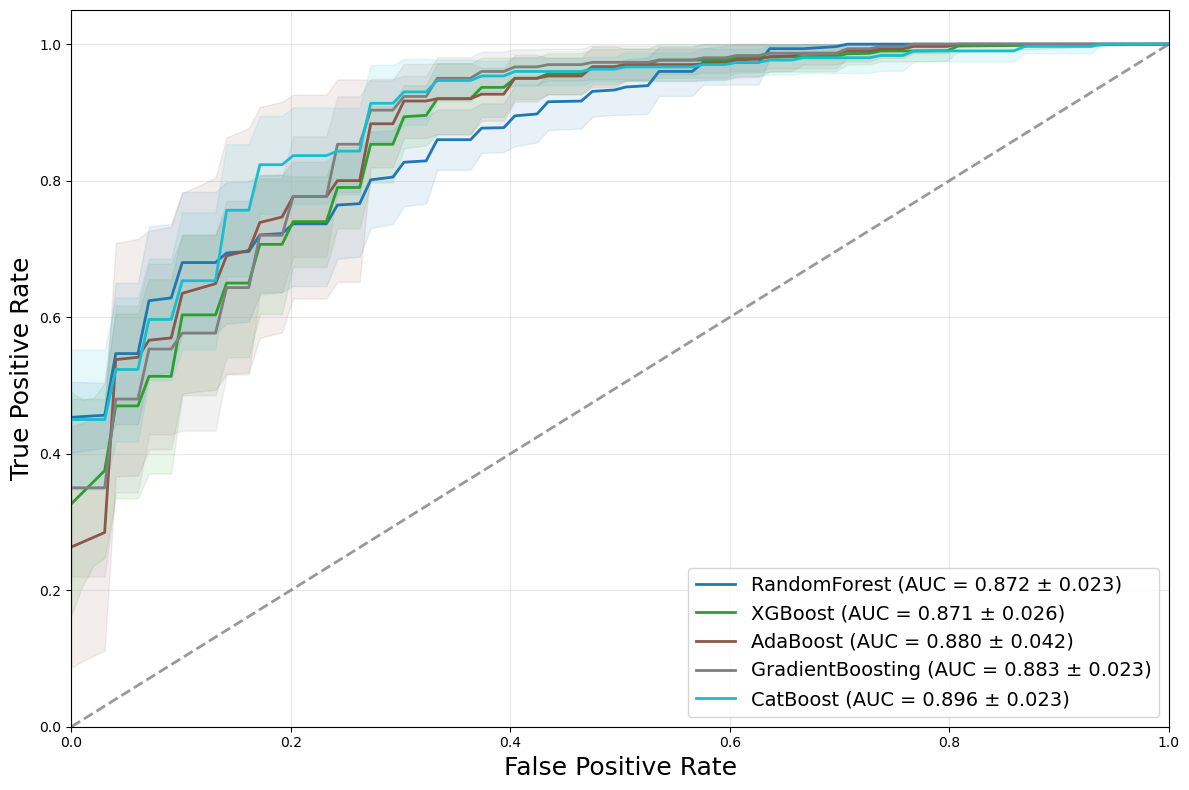

In [ ]:
# Plot ROC curves for all hyperoptimized static ensembles
if 'ses_roc_curves' in locals() and len(ses_roc_curves) > 0:
    plt.figure(figsize=(12, 8))
    mean_fpr = np.linspace(0, 1, 100)
    static_ensemble_names = ['RandomForest', 'XGBoost', 'AdaBoost', 'GradientBoosting', 'CatBoost']
    colors = plt.cm.get_cmap('tab10', len(static_ensemble_names))

    for i, clf_name in enumerate(static_ensemble_names):
        if clf_name in ses_roc_curves and len(ses_roc_curves[clf_name]) > 0:
            tprs = []
            aucs = []
            for fpr, tpr in ses_roc_curves[clf_name]:
                tprs.append(np.interp(mean_fpr, fpr, tpr))
                aucs.append(auc(fpr, tpr))
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            plt.plot(mean_fpr, mean_tpr, color=colors(i), lw=2,
                     label=f'{clf_name} (AUC = {mean_auc:.3f} ± {std_auc:.3f})')
            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors(i), alpha=0.1)

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.legend(loc="lower right", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc1.svg', format='svg', bbox_inches='tight')
    print("ROC curves for hyperoptimized static ensembles saved as roc1.svg")
    plt.show()
else:
    print("No ROC curve data available for hyperoptimized static ensembles.")

STATISTICAL SIGNIFICANCE ANALYSIS
Friedman Test Statistic: 14.9622
p-value: 0.004780
✓ Result: Significant differences found between classifiers
Critical Difference: 1.9288

📈 CLASSIFIER RANKINGS (lower rank is better):
----------------------------------------
 1. CatBoost       : 1.750
 2. AdaBoost       : 2.300
 3. GradientBoosting: 3.450
 4. XGBoost        : 3.550
 5. RandomForest   : 3.950
Friedman Test Statistic: 14.9622
p-value: 0.004780
✓ Result: Significant differences found between classifiers
Critical Difference: 1.9288

📈 CLASSIFIER RANKINGS (lower rank is better):
----------------------------------------
 1. CatBoost       : 1.750
 2. AdaBoost       : 2.300
 3. GradientBoosting: 3.450
 4. XGBoost        : 3.550
 5. RandomForest   : 3.950


<Figure size 1600x800 with 0 Axes>

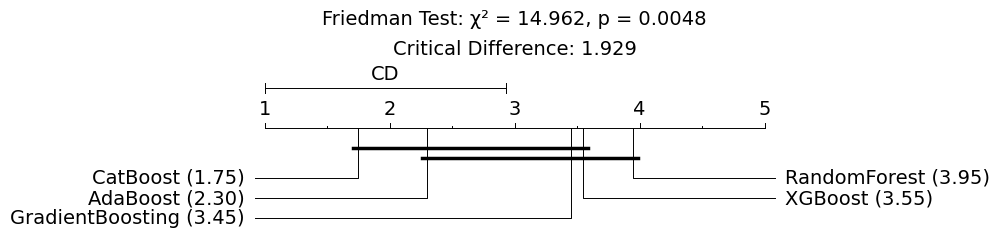

In [ ]:
# Enhanced statistical analysis with better visualization
if 'accuracy_scores' in locals() and len(accuracy_scores) > 1:
    print("="*60)
    print("STATISTICAL SIGNIFICANCE ANALYSIS")
    print("="*60)
    
    df = pd.DataFrame(ses_accuracy_scores)
    scores = [df[col].values for col in df.columns]
    
    try:
        stat, p = friedmanchisquare(*scores)
        print(f'Friedman Test Statistic: {stat:.4f}')
        print(f'p-value: {p:.6f}')
        
        if p < 0.05:
            print("✓ Result: Significant differences found between classifiers")
        else:
            print("⚠ Result: No significant differences found between classifiers")
        
        ranks = df.rank(axis=1, method='average', ascending=False)
        average_ranks = ranks.mean().values
        n_datasets = df.shape[0]
        
        cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
        print(f'Critical Difference: {cd:.4f}')
        
        # Enhanced ranking display
        ranking_data = list(zip(df.columns, average_ranks))
        ranking_data.sort(key=lambda x: x[1])
        
        print(f"\n📈 CLASSIFIER RANKINGS (lower rank is better):")
        print("-" * 40)
        for i, (clf, rank) in enumerate(ranking_data, 1):
            print(f"{i:2d}. {clf:<15}: {rank:.3f}")
        
        # Critical Difference diagram with enhanced styling
        classifiers_with_ranks = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]
        plt.figure(figsize=(16, 8))
        graph_ranks(average_ranks, classifiers_with_ranks, cd=cd, width=8, textspace=1.5)
        
        # Add statistical info
        plt.text(0.5, 1.22, f'Friedman Test: χ² = {stat:.3f}, p = {p:.4f}', 
                horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
        plt.text(0.5, 1.05, f'Critical Difference: {cd:.3f}', 
                horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
        
        if CONFIG['SAVE_PLOTS']:
            plt.savefig('critical_difference_diagram.svg', format='svg', bbox_inches='tight')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Statistical analysis failed: {e}")
else:
    print("Insufficient data for statistical analysis.")

### TRAINING : Dynamic Ensemble classifiers

In [ ]:
# CHANGE 1: Use separate dictionaries for DES models
des_metric_sums_des = {
    'KNORAE': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'KNORAU': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'KNOP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESMI': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'METADES': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESKNN': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'DESP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNORA-U': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNORA-E': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-METADES': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-DESKNN': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-DESP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
    'FIRE-KNOP': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0},
}

des_conf_matrices_des = {
    'KNORAE': [],
    'KNORAU': [],
    'KNOP': [],
    'DESMI': [],
    'METADES': [],
    'DESKNN': [],
    'DESP': [],
    'FIRE-KNORA-U': [],
    'FIRE-KNORA-E': [],
    'FIRE-METADES': [],
    'FIRE-DESKNN': [],
    'FIRE-DESP': [],
    'FIRE-KNOP': [],
}

des_roc_curves = defaultdict(list)
des_roc_aucs = defaultdict(list)
des_accuracy_scores = defaultdict(list)
des_precision_scores = defaultdict(list)
des_recall_scores = defaultdict(list)
des_f1_scores = defaultdict(list)
feature_importance_runs = []

base_classifiers = {
    'SVC': SVC(probability=True, kernel = 'rbf', C = 1.5, gamma = 'auto'),
    'RF': RandomForestClassifier(n_estimators=143, criterion='entropy', max_depth=15, random_state=0),
    'XGB': XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=0),
    'GB': GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=0.05),
    'AB': AdaBoostClassifier(n_estimators=400, learning_rate=0.1),
    'CB': CatBoostClassifier(depth = 3, iterations = 168, learning_rate = 0.1, verbose = 0),
}

random_state = 0

for random_state in range(10):
    print(f"Processing for Random State: {random_state}")

    X = splitted_dataset.drop('BCaseControlStatus', axis=1)
    y = splitted_dataset['BCaseControlStatus']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)
    
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]
    
    original_columns = X.columns.tolist()

    smote = SMOTE(random_state=random_state)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    print(f"Number of test labels before resampling: {y_test.value_counts()}")
    
    # Fix: Use the minimum class count for undersampling
    min_class_count = min(y_test.value_counts())
    sampling_strategy_undersample = {0: min_class_count, 1: min_class_count}
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy_undersample, random_state=random_state)
    X_test, y_test = rus.fit_resample(X_test, y_test) 

    print(f"Number of test labels after resampling: {y_test.value_counts()}")

    scaler = MinMaxScaler()
    X_res = scaler.fit_transform(X_res)
    X_test = scaler.transform(X_test)
    
    X_res = pd.DataFrame(X_res, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    xgb_fs = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
    xgb_fs.fit(X_res, y_res)

    feature_importances = xgb_fs.feature_importances_
    indices = np.argsort(feature_importances)[::-1]
    top_50_features = [original_columns[i] for i in indices[:50]]
    current_run_features = {original_columns[i]: feature_importances[i] for i in indices[:50]}
    
    feature_importance_runs.append(current_run_features)

    X_res_fi = X_res[top_50_features]
    X_test_fi = X_test[top_50_features]
    
    model_pool = list(base_classifiers.values())
    
    for clf in model_pool:
        clf.fit(X_res_fi, y_res)
    
    des_models = {
        'KNORAE': KNORAE(pool_classifiers=model_pool, random_state=random_state),
        'KNORAU': KNORAU(pool_classifiers=model_pool, random_state=random_state),
        'DESMI': DESMI(pool_classifiers=model_pool, random_state=random_state),
        'METADES': METADES(pool_classifiers=model_pool, random_state=random_state),
        'DESKNN': DESKNN(pool_classifiers=model_pool, random_state=random_state),
        'DESP': DESP(pool_classifiers=model_pool, random_state=random_state),
        'KNOP': KNOP(pool_classifiers=model_pool, random_state=random_state, k=9),
        'FIRE-KNORA-U': KNORAU(pool_classifiers=model_pool, DFP=True, k=9, random_state = random_state),
        'FIRE-KNORA-E': KNORAE(pool_classifiers=model_pool, DFP=True, k=9, random_state = random_state),
        'FIRE-METADES': METADES(pool_classifiers=model_pool, DFP=True, k=9, random_state = random_state),
        'FIRE-DESKNN': DESKNN(pool_classifiers=model_pool, DFP=True, k=9, random_state = random_state),
        'FIRE-DESP': DESP(pool_classifiers=model_pool, DFP=True, k=9, random_state = random_state),
        'FIRE-KNOP': KNOP(pool_classifiers=model_pool, DFP=True, k=40, random_state = random_state)
    }

    for des_name, des_model in des_models.items():
        accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
            des_model, X_res_fi, y_res, X_test_fi, y_test, clf_name=des_name
        )
        
        # CHANGE 2: Store results in DES-specific dictionaries
        des_metric_sums_des[des_name]['accuracy'] += accuracy
        des_metric_sums_des[des_name]['precision'] += precision
        des_metric_sums_des[des_name]['recall'] += recall
        des_metric_sums_des[des_name]['f1'] += f1
        des_conf_matrices_des[des_name].append(conf_matrix)
        des_roc_curves[des_name].append((fpr, tpr))
       
        des_roc_aucs[des_name].append(roc_auc)
        des_accuracy_scores[des_name].append(accuracy)
        des_precision_scores[des_name].append(precision)
        des_recall_scores[des_name].append(recall)
        des_f1_scores[des_name].append(f1)

        print(f'Confusion Matrix for {des_name} at Random State {random_state}:\n{conf_matrix}\n')

Processing for Random State: 0
Number of test labels before resampling: 1    30
0    30
Name: BCaseControlStatus, dtype: int64
Number of test labels after resampling: 0    30
1    30
Name: BCaseControlStatus, dtype: int64
KNORAE - Accuracy: 0.8333, Precision: 0.8394, Recall: 0.8333, F1-Score: 0.8326, AUC: 0.8944
Confusion Matrix for KNORAE at Random State 0:
[[23  7]
 [ 3 27]]

KNORAU - Accuracy: 0.8333, Precision: 0.8394, Recall: 0.8333, F1-Score: 0.8326, AUC: 0.8822
Confusion Matrix for KNORAU at Random State 0:
[[23  7]
 [ 3 27]]

DESMI - Accuracy: 0.8000, Precision: 0.8000, Recall: 0.8000, F1-Score: 0.8000, AUC: 0.8889
Confusion Matrix for DESMI at Random State 0:
[[24  6]
 [ 6 24]]

METADES - Accuracy: 0.8000, Precision: 0.8000, Recall: 0.8000, F1-Score: 0.8000, AUC: 0.8944
Confusion Matrix for METADES at Random State 0:
[[24  6]
 [ 6 24]]

DESKNN - Accuracy: 0.8000, Precision: 0.8054, Recall: 0.8000, F1-Score: 0.7991, AUC: 0.8822
Confusion Matrix for DESKNN at Random State 0:
[[2


DES MODELS PERFORMANCE ANALYSIS
KNORAE - Accuracy: 0.8050 ± 0.0308, Precision: 0.8105 ± 0.0321, Recall: 0.8050 ± 0.0308, F1-Score: 0.8042 ± 0.0308, AUC: 0.8821
KNORAU - Accuracy: 0.8050 ± 0.0308, Precision: 0.8105 ± 0.0321, Recall: 0.8050 ± 0.0308, F1-Score: 0.8042 ± 0.0308, AUC: 0.8541
KNOP - Accuracy: 0.8033 ± 0.0296, Precision: 0.8091 ± 0.0311, Recall: 0.8033 ± 0.0296, F1-Score: 0.8024 ± 0.0296, AUC: 0.8437
DESMI - Accuracy: 0.7800 ± 0.0379, Precision: 0.7861 ± 0.0372, Recall: 0.7800 ± 0.0379, F1-Score: 0.7787 ± 0.0385, AUC: 0.8817
METADES - Accuracy: 0.8033 ± 0.0314, Precision: 0.8078 ± 0.0326, Recall: 0.8033 ± 0.0314, F1-Score: 0.8026 ± 0.0315, AUC: 0.8827
DESKNN - Accuracy: 0.7850 ± 0.0462, Precision: 0.7937 ± 0.0455, Recall: 0.7850 ± 0.0462, F1-Score: 0.7832 ± 0.0471, AUC: 0.8799
DESP - Accuracy: 0.8117 ± 0.0373, Precision: 0.8161 ± 0.0375, Recall: 0.8117 ± 0.0373, F1-Score: 0.8110 ± 0.0375, AUC: 0.8837
FIRE-KNORA-U - Accuracy: 0.8050 ± 0.0308, Precision: 0.8105 ± 0.0321, Recal

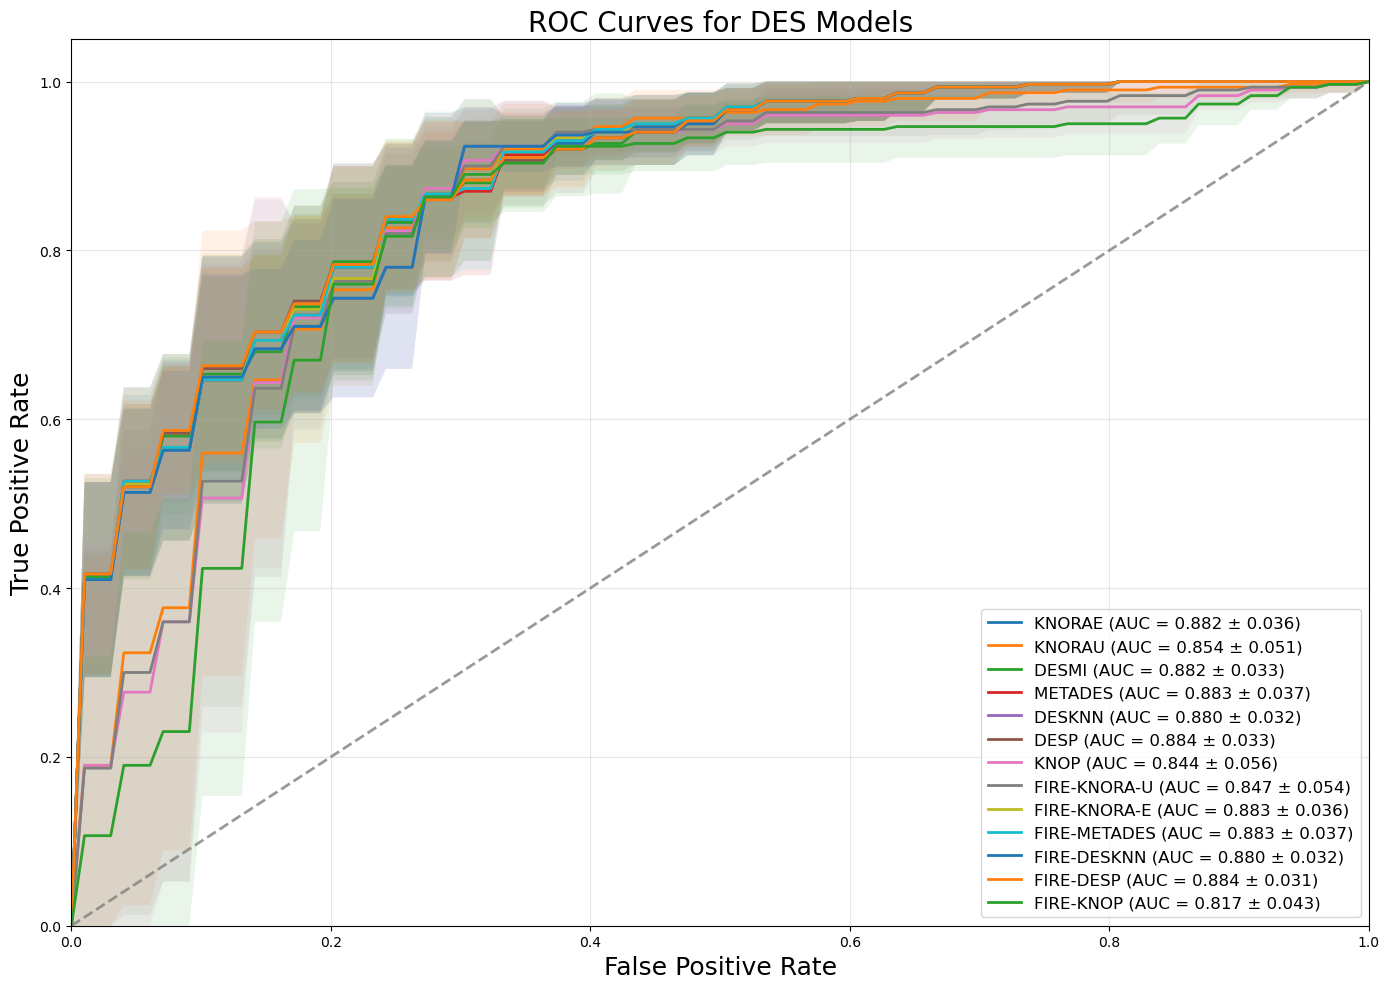


STANDARD DES vs FIRE-DES COMPARISON:
Standard DES - Avg Accuracy: 0.7990, Avg AUC: 0.8725
FIRE-DES    - Avg Accuracy: 0.8025, Avg AUC: 0.8656
Improvement - Accuracy: 0.35%, AUC: -0.69%


In [ ]:
# Analyze DES models performance and visualize results
print("\nDES MODELS PERFORMANCE ANALYSIS")
print("=" * 60)

# Calculate average metrics over all random states for DES models
des_results = []
for des_name, metrics in des_metric_sums_des.items():
    # Use 10 instead of CONFIG['RANDOM_STATES'] since we can see the loop runs 10 times
    avg_accuracy = metrics['accuracy'] / 10
    avg_precision = metrics['precision'] / 10
    avg_recall = metrics['recall'] / 10
    avg_f1 = metrics['f1'] / 10
    
    # Calculate standard deviations
    std_accuracy = np.std(des_accuracy_scores[des_name]) if des_name in des_accuracy_scores else 0
    std_precision = np.std(des_precision_scores[des_name]) if des_name in des_precision_scores else 0
    std_recall = np.std(des_recall_scores[des_name]) if des_name in des_recall_scores else 0
    std_f1 = np.std(des_f1_scores[des_name]) if des_name in des_f1_scores else 0
    avg_auc = np.mean(des_roc_aucs[des_name]) if des_name in des_roc_aucs else 0
    
    print(f'{des_name} - Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}, Precision: {avg_precision:.4f} ± {std_precision:.4f}, Recall: {avg_recall:.4f} ± {std_recall:.4f}, F1-Score: {avg_f1:.4f} ± {std_f1:.4f}, AUC: {avg_auc:.4f}')
    
    des_results.append({
        'Model': des_name,
        'Accuracy': avg_accuracy,
        'Precision': avg_precision,
        'Recall': avg_recall,
        'F1': avg_f1,
        'AUC': avg_auc
    })

# Sort DES models by accuracy
des_results_df = pd.DataFrame(des_results).sort_values('Accuracy', ascending=False)
print("\nDES MODELS RANKED BY ACCURACY:")
print(des_results_df[['Model', 'Accuracy', 'F1', 'AUC']].to_string(index=False))

# Plot ROC curves for all DES models
plt.figure(figsize=(14, 10))
mean_fpr = np.linspace(0, 1, 100)
colors = plt.cm.get_cmap('tab20', len(des_roc_curves))

for i, (des_name, curves) in enumerate(des_roc_curves.items()):
    if len(curves) > 0:
        tprs = []
        aucs = []
        for fpr, tpr in curves:
            # Make sure fpr and tpr are properly formatted
            if len(fpr) > 0 and len(tpr) > 0:
                tprs.append(np.interp(mean_fpr, fpr, tpr))
                tprs[-1][0] = 0.0  # Force start at 0
                aucs.append(auc(fpr, tpr))
                
        if tprs:  # Check if we have valid TPR values
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0  # Force end at 1
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            
            plt.plot(mean_fpr, mean_tpr, lw=2,
                     label=f'{des_name} (AUC = {mean_auc:.3f} ± {std_auc:.3f})')
            
            # Add confidence bands
            if len(tprs) > 1:  # Only if we have multiple runs
                std_tpr = np.std(tprs, axis=0)
                tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
                tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
                plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.1)

# Add diagonal line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curves for DES Models', fontsize=20)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

# Save plot - assuming CONFIG['SAVE_PLOTS'] is True
plt.savefig('des_roc_curves.svg', format='svg', bbox_inches='tight')
print("\n✓ ROC curves saved as 'des_roc_curves.svg'")

plt.tight_layout()
plt.show()

# Compare standard DES vs FIRE-DES variants
std_des_models = [m for m in des_results_df['Model'] if not m.startswith('FIRE-')]
fire_des_models = [m for m in des_results_df['Model'] if m.startswith('FIRE-')]

std_des_acc = des_results_df[des_results_df['Model'].isin(std_des_models)]['Accuracy'].mean()
fire_des_acc = des_results_df[des_results_df['Model'].isin(fire_des_models)]['Accuracy'].mean()

std_des_auc = des_results_df[des_results_df['Model'].isin(std_des_models)]['AUC'].mean()
fire_des_auc = des_results_df[des_results_df['Model'].isin(fire_des_models)]['AUC'].mean()

print("\nSTANDARD DES vs FIRE-DES COMPARISON:")
print(f"Standard DES - Avg Accuracy: {std_des_acc:.4f}, Avg AUC: {std_des_auc:.4f}")
print(f"FIRE-DES    - Avg Accuracy: {fire_des_acc:.4f}, Avg AUC: {fire_des_auc:.4f}")
print(f"Improvement - Accuracy: {(fire_des_acc - std_des_acc) * 100:.2f}%, AUC: {(fire_des_auc - std_des_auc) * 100:.2f}%")

Friedman Test Statistic: 29.23234390992833, p-value: 0.003638658567203066
Critical Difference: 5.769621047847687


<Figure size 1400x1000 with 0 Axes>

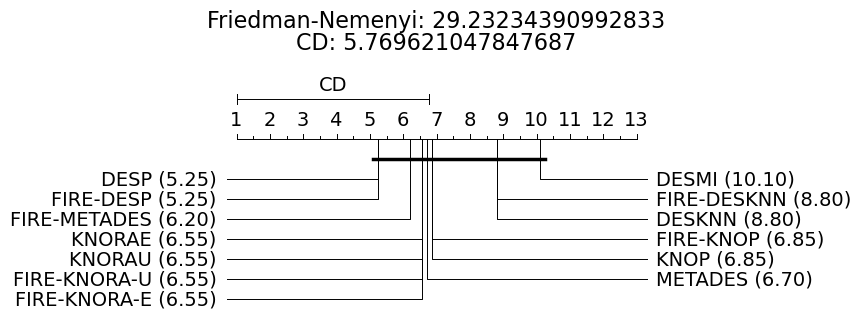

In [ ]:
df = pd.DataFrame(des_accuracy_scores)
scores = [df[col].values for col in df.columns]

stat, p = friedmanchisquare(*scores)
print(f'Friedman Test Statistic: {stat}, p-value: {p}')

ranks = df.rank(axis=1, method='average', ascending=False)
average_ranks = ranks.mean().values

n_datasets = df.shape[0]
alpha = 0.05

cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
print(f'Critical Difference: {cd}')

classifiers = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]

plt.figure(figsize=(14, 10))

graph_ranks(average_ranks, classifiers, cd=cd, width=6, textspace=1)
plt.xlabel('Classifiers')

plt.text(0.5, 1.19, f'Friedman-Nemenyi: {stat}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=16)
plt.text(0.5, 1.10, f'CD: {cd}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=16)

plt.tight_layout()

COMPREHENSIVE FRIEDMAN TEST ANALYSIS: ALL MODELS
✓ Added SES_RandomForest: 10 scores
✓ Added SES_XGBoost: 10 scores
✓ Added SES_AdaBoost: 10 scores
✓ Added SES_GradientBoosting: 10 scores
✓ Added SES_CatBoost: 10 scores
✓ Added DES_KNORAE: 10 scores
✓ Added DES_KNORAU: 10 scores
✓ Added DES_DESMI: 10 scores
✓ Added DES_METADES: 10 scores
✓ Added DES_DESKNN: 10 scores
✓ Added DES_DESP: 10 scores
✓ Added DES_KNOP: 10 scores
✓ Added DES_FIRE-KNORA-U: 10 scores
✓ Added DES_FIRE-KNORA-E: 10 scores
✓ Added DES_FIRE-METADES: 10 scores
✓ Added DES_FIRE-DESKNN: 10 scores
✓ Added DES_FIRE-DESP: 10 scores
✓ Added DES_FIRE-KNOP: 10 scores

Total models collected: 18
Score lengths - Min: 10, Max: 10

DataFrame shape: (10, 18)

MODEL PERFORMANCE SUMMARY:
----------------------------------------------------------------------
Rank Model                     Mean     Std      Category    
----------------------------------------------------------------------
 1.  CatBoost                  0.8183   0.033

/home/researchsrv1/clement/DES4DepressionTest/code/top5_critical_difference_diagram.svg

<Figure size 1800x1000 with 0 Axes>

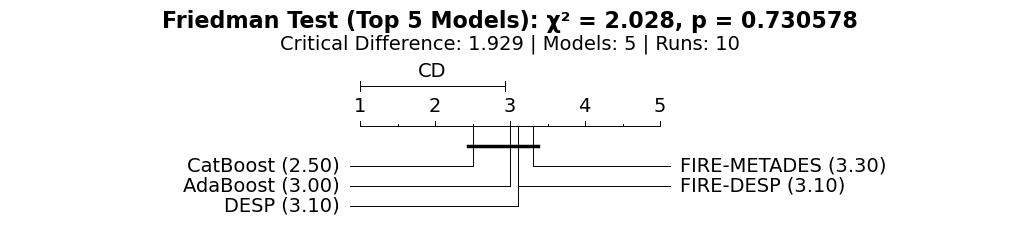


🏆 TOP 5 CATEGORY DISTRIBUTION:
--------------------------------------------------
   SES: 2 models
   DES: 3 models

• Dominant category in top 5: DES

TOP 5 MODELS ANALYSIS SUMMARY
• Total models analyzed: 18
• Top 5 models selected for analysis
• Friedman test p-value: 0.73057765
• Critical difference: 1.9288
• Best performing model: SES_CatBoost (rank: 2.500)


In [ ]:
# COMPREHENSIVE FRIEDMAN ANALYSIS OF ALL MODELS
print("="*80)
print("COMPREHENSIVE FRIEDMAN TEST ANALYSIS: ALL MODELS")
print("="*80)

# Collect all available models from different categories
all_models_dict = {}

# 1. Classical models (if available)
if 'accuracy_scores' in locals() and len(accuracy_scores) > 0:
    classical_names = ['DT', 'LR', 'NB', 'KNN', 'MLP', 'SVC', 'ExtraTrees', 'Bagging']
    for model in classical_names:
        if model in accuracy_scores and len(accuracy_scores[model]) > 0:
            all_models_dict[f"Classical_{model}"] = accuracy_scores[model]
            print(f"✓ Added Classical_{model}: {len(accuracy_scores[model])} scores")

# 2. Static/Ensemble models (SES)
if 'ses_accuracy_scores' in locals() and len(ses_accuracy_scores) > 0:
    for model, scores in ses_accuracy_scores.items():
        if len(scores) > 0:
            all_models_dict[f"SES_{model}"] = scores
            print(f"✓ Added SES_{model}: {len(scores)} scores")

# 3. Dynamic Ensemble Selection models (DES)
if 'des_accuracy_scores' in locals() and len(des_accuracy_scores) > 0:
    for model, scores in des_accuracy_scores.items():
        if len(scores) > 0:
            all_models_dict[f"DES_{model}"] = scores
            print(f"✓ Added DES_{model}: {len(scores)} scores")

print(f"\nTotal models collected: {len(all_models_dict)}")

# Ensure all models have the same number of scores
if len(all_models_dict) > 0:
    score_lengths = [len(scores) for scores in all_models_dict.values()]
    min_length = min(score_lengths)
    max_length = max(score_lengths)
    
    print(f"Score lengths - Min: {min_length}, Max: {max_length}")
    
    # If different lengths, truncate to minimum
    if min_length != max_length:
        print(f"⚠ Truncating all scores to minimum length: {min_length}")
        for model_name in all_models_dict:
            all_models_dict[model_name] = all_models_dict[model_name][:min_length]
    
    # Create DataFrame for analysis
    comprehensive_df = pd.DataFrame(all_models_dict)
    print(f"\nDataFrame shape: {comprehensive_df.shape}")
    
    # Display basic statistics
    print(f"\nMODEL PERFORMANCE SUMMARY:")
    print("-" * 70)
    model_stats = []
    for model_name, scores in all_models_dict.items():
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        model_stats.append((model_name, mean_score, std_score))
    
    # Sort by mean performance
    model_stats.sort(key=lambda x: x[1], reverse=True)
    
    print(f"{'Rank':<4} {'Model':<25} {'Mean':<8} {'Std':<8} {'Category':<12}")
    print("-" * 70)
    for i, (model, mean_acc, std_acc) in enumerate(model_stats, 1):
        if model.startswith("Classical_"):
            category = "Classical"
        elif model.startswith("SES_"):
            category = "SES"
        elif model.startswith("DES_"):
            category = "DES"
        else:
            category = "Other"
        
        print(f"{i:2d}.  {model[len(category)+1:]:<25} {mean_acc:.4f}   {std_acc:.4f}   {category:<12}")
    
    # Select top 5 models for Friedman analysis
    top5_models = [model[0] for model in model_stats[:5]]
    top5_df = comprehensive_df[top5_models]
    
    print(f"\n" + "="*60)
    print("FRIEDMAN TEST RESULTS: TOP 5 MODELS")
    print("="*60)
    
    # Prepare data for Friedman test (only top 5 models)
    scores_arrays = [top5_df[col].values for col in top5_df.columns]
    
    try:
        stat, p_value = friedmanchisquare(*scores_arrays)
        
        print(f"Friedman Test Statistic: {stat:.6f}")
        print(f"p-value: {p_value:.8f}")
        print(f"Number of models: {len(top5_df.columns)}")
        print(f"Number of datasets/runs: {len(top5_df)}")
        
        # Significance interpretation
        alpha = 0.05
        if p_value < alpha:
            significance = "SIGNIFICANT"
            interpretation = "There are statistically significant differences between the top 5 models."
        else:
            significance = "NOT SIGNIFICANT"
            interpretation = "No statistically significant differences found between the top 5 models."
        
        print(f"\nResult at α = {alpha}: {significance}")
        print(f"Interpretation: {interpretation}")
        
        # Calculate ranks and Critical Difference
        ranks_df = top5_df.rank(axis=1, method='average', ascending=False)
        average_ranks = ranks_df.mean().values
        model_names = top5_df.columns.tolist()
        
        # Critical Difference calculation
        n_datasets = len(top5_df)
        cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
        
        print(f"\nCritical Difference (CD): {cd:.4f}")
        
        # Ranking analysis
        print(f"\n📊 TOP 5 MODEL RANKINGS (Average Rank - lower is better):")
        print("-" * 65)
        rank_data = list(zip(model_names, average_ranks))
        rank_data.sort(key=lambda x: x[1])  # Sort by rank (ascending)
        
        print(f"{'Rank':<4} {'Model':<25} {'Avg Rank':<10} {'Category':<12}")
        print("-" * 65)
        for i, (model, avg_rank) in enumerate(rank_data, 1):
            if model.startswith("Classical_"):
                category = "Classical"
                display_name = model[10:]  # Remove "Classical_"
            elif model.startswith("SES_"):
                category = "SES"
                display_name = model[4:]   # Remove "SES_"
            elif model.startswith("DES_"):
                category = "DES"
                display_name = model[4:]   # Remove "DES_"
            else:
                category = "Other"
                display_name = model
            
            print(f"{i:2d}.  {display_name:<25} {avg_rank:.3f}      {category:<12}")
        
        # Generate Critical Difference Diagram for top 5
        print(f"\n📈 GENERATING CRITICAL DIFFERENCE DIAGRAM FOR TOP 5 MODELS...")
        
        # Create enhanced labels with ranks
        enhanced_labels = []
        for model, rank in zip(model_names, average_ranks):
            if model.startswith("Classical_"):
                display_name = model[10:]
            elif model.startswith("SES_"):
                display_name = model[4:]
            elif model.startswith("DES_"):
                display_name = model[4:]
            else:
                display_name = model
            enhanced_labels.append(f"{display_name} ({rank:.2f})")
        
        # Plot Critical Difference diagram
        plt.figure(figsize=(18, 10))
        graph_ranks(average_ranks, enhanced_labels, cd=cd, width=10, textspace=3.5)
        
        # Add statistical information with more spacing
        plt.text(0.5, 1.20, f'Friedman Test (Top 5 Models): χ² = {stat:.3f}, p = {p_value:.6f}', 
                horizontalalignment='center', transform=plt.gca().transAxes, fontsize=16, weight='bold')
        plt.text(0.5, 1.07, f'Critical Difference: {cd:.3f} | Models: {len(model_names)} | Runs: {n_datasets}', 
                horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
        
        if CONFIG['SAVE_PLOTS']:
            filename = 'top5_critical_difference_diagram.svg'
            plt.savefig(filename, format='svg', bbox_inches='tight')
            print(f"✓ Critical Difference diagram saved as: {filename}")
            display(FileLink(filename))
        
        plt.tight_layout()
        plt.show()
        
        # Category analysis of top 5
        print(f"\n🏆 TOP 5 CATEGORY DISTRIBUTION:")
        print("-" * 50)
        category_counts = {'Classical': 0, 'SES': 0, 'DES': 0, 'Other': 0}
        
        for model in top5_models:
            if model.startswith("Classical_"):
                category_counts['Classical'] += 1
            elif model.startswith("SES_"):
                category_counts['SES'] += 1
            elif model.startswith("DES_"):
                category_counts['DES'] += 1
            else:
                category_counts['Other'] += 1
        
        for category, count in category_counts.items():
            if count > 0:
                print(f"   {category}: {count} models")
        
        # Determine dominant category
        if category_counts:
            winner_category = max(category_counts, key=category_counts.get)
            print(f"\n• Dominant category in top 5: {winner_category}")
        
        # Final summary
        print(f"\n" + "="*80)
        print("TOP 5 MODELS ANALYSIS SUMMARY")
        print("="*80)
        print(f"• Total models analyzed: {len(all_models_dict)}")
        print(f"• Top 5 models selected for analysis")
        print(f"• Friedman test p-value: {p_value:.8f}")
        print(f"• Critical difference: {cd:.4f}")
        print(f"• Best performing model: {rank_data[0][0]} (rank: {rank_data[0][1]:.3f})")
        
    except Exception as e:
        print(f"❌ Error in Friedman test: {e}")
        print("This might be due to insufficient data or identical performances.")

else:
    print("❌ No model data found for analysis.")
    print("Please ensure that model training has been completed and accuracy scores are available.")


In [ ]:
from scipy.stats import mannwhitneyu

# COMPREHENSIVE COMPARISON: SES vs DES - TOP 8 MODELS ANALYSIS
print("="*80)
print("COMPREHENSIVE COMPARISON: STATIC ENSEMBLE SELECTION (SES) vs DYNAMIC ENSEMBLE SELECTION (DES)")
print("="*80)

# Collect all SES and DES models with their performance metrics
ses_models = {}
des_models = {}

# SES Models (from ses_accuracy_scores, ses_f1_scores, ses_roc_aucs)
if 'ses_accuracy_scores' in locals():
    for model_name, scores in ses_accuracy_scores.items():
        if len(scores) > 0:
            ses_models[f"SES_{model_name}"] = {
                'accuracy': np.mean(scores),
                'accuracy_std': np.std(scores),
                'auc': np.mean(ses_roc_aucs[model_name]) if model_name in ses_roc_aucs else 0,
                'auc_std': np.std(ses_roc_aucs[model_name]) if model_name in ses_roc_aucs else 0,
                'f1': np.mean(ses_f1_scores[model_name]) if model_name in ses_f1_scores else 0,
                'category': 'SES'
            }

# DES Models (from des_accuracy_scores, des_f1_scores, des_roc_aucs)
if 'des_accuracy_scores' in locals():
    for model_name, scores in des_accuracy_scores.items():
        if len(scores) > 0:
            des_models[f"DES_{model_name}"] = {
                'accuracy': np.mean(scores),
                'accuracy_std': np.std(scores),
                'auc': np.mean(des_roc_aucs[model_name]) if model_name in des_roc_aucs else 0,
                'auc_std': np.std(des_roc_aucs[model_name]) if model_name in des_roc_aucs else 0,
                'f1': np.mean(des_f1_scores[model_name]) if model_name in des_f1_scores else 0,
                'category': 'DES'
            }

# Combine all models
all_models = {**ses_models, **des_models}

print(f"\nTotal SES models: {len(ses_models)}")
print(f"Total DES models: {len(des_models)}")
print(f"Total models for comparison: {len(all_models)}")

# 1) TOP 8 MODELS BY ACCURACY
print("\n" + "="*60)
print("1) TOP 8 MODELS BY ACCURACY")
print("="*60)

top_8_accuracy = sorted(all_models.items(), key=lambda x: x[1]['accuracy'], reverse=True)[:8]

print(f"{'Rank':<4} {'Model':<20} {'Category':<5} {'Accuracy':<12} {'Std':<8} {'AUC':<8}")
print("-" * 70)

ses_count_acc = 0
des_count_acc = 0

for i, (model_name, metrics) in enumerate(top_8_accuracy, 1):
    category = metrics['category']
    display_name = model_name.replace('SES_', '').replace('DES_', '')
    
    if category == 'SES':
        ses_count_acc += 1
    else:
        des_count_acc += 1
    
    print(f"{i:2d}.  {display_name:<20} {category:<5} {metrics['accuracy']:.4f}±{metrics['accuracy_std']:.3f} {metrics['auc']:.3f}")

print(f"\nAccuracy Summary:")
print(f"  SES models in top 8: {ses_count_acc}")
print(f"  DES models in top 8: {des_count_acc}")

# 2) TOP 8 MODELS BY AUC-ROC
print("\n" + "="*60)
print("2) TOP 8 MODELS BY AUC-ROC")
print("="*60)

top_8_auc = sorted(all_models.items(), key=lambda x: x[1]['auc'], reverse=True)[:8]

print(f"{'Rank':<4} {'Model':<20} {'Category':<5} {'AUC':<12} {'Std':<8} {'Accuracy':<8}")
print("-" * 70)

ses_count_auc = 0
des_count_auc = 0

for i, (model_name, metrics) in enumerate(top_8_auc, 1):
    category = metrics['category']
    display_name = model_name.replace('SES_', '').replace('DES_', '')
    
    if category == 'SES':
        ses_count_auc += 1
    else:
        des_count_auc += 1
    
    print(f"{i:2d}.  {display_name:<20} {category:<5} {metrics['auc']:.4f}±{metrics['auc_std']:.3f} {metrics['accuracy']:.3f}")

print(f"\nAUC-ROC Summary:")
print(f"  SES models in top 8: {ses_count_auc}")
print(f"  DES models in top 8: {des_count_auc}")

# Statistical comparison between SES and DES categories
print("\n" + "="*60)
print("STATISTICAL CATEGORY COMPARISON")
print("="*60)

# Collect all SES and DES accuracy scores for comparison
ses_all_accuracies = []
des_all_accuracies = []
ses_all_aucs = []
des_all_aucs = []

for model_name, metrics in all_models.items():
    if metrics['category'] == 'SES':
        # Get original scores for statistical testing
        original_name = model_name.replace('SES_', '')
        if original_name in ses_accuracy_scores:
            ses_all_accuracies.extend(ses_accuracy_scores[original_name])
            if original_name in ses_roc_aucs:
                ses_all_aucs.extend(ses_roc_aucs[original_name])
    else:
        # Get original scores for statistical testing
        original_name = model_name.replace('DES_', '')
        if original_name in des_accuracy_scores:
            des_all_accuracies.extend(des_accuracy_scores[original_name])
            if original_name in des_roc_aucs:
                des_all_aucs.extend(des_roc_aucs[original_name])

# Calculate category statistics
ses_avg_acc = np.mean(ses_all_accuracies) if len(ses_all_accuracies) > 0 else 0
des_avg_acc = np.mean(des_all_accuracies) if len(des_all_accuracies) > 0 else 0
ses_std_acc = np.std(ses_all_accuracies) if len(ses_all_accuracies) > 0 else 0
des_std_acc = np.std(des_all_accuracies) if len(des_all_accuracies) > 0 else 0

ses_avg_auc = np.mean(ses_all_aucs) if len(ses_all_aucs) > 0 else 0
des_avg_auc = np.mean(des_all_aucs) if len(des_all_aucs) > 0 else 0
ses_std_auc = np.std(ses_all_aucs) if len(ses_all_aucs) > 0 else 0
des_std_auc = np.std(des_all_aucs) if len(des_all_aucs) > 0 else 0

print(f"Category Performance Comparison:")
print(f"{'Category':<12} {'Avg Accuracy':<15} {'Avg AUC':<12} {'Sample Size':<12}")
print("-" * 55)
print(f"{'SES':<12} {ses_avg_acc:.4f}±{ses_std_acc:.3f}   {ses_avg_auc:.4f}±{ses_std_auc:.3f} {len(ses_all_accuracies):<12}")
print(f"{'DES':<12} {des_avg_acc:.4f}±{des_std_acc:.3f}   {des_avg_auc:.4f}±{des_std_auc:.3f} {len(des_all_accuracies):<12}")

# Statistical significance test
try:
    
    if len(ses_all_accuracies) > 0 and len(des_all_accuracies) > 0:
        # Mann-Whitney U test for accuracy
        statistic_acc, p_value_acc = mannwhitneyu(ses_all_accuracies, des_all_accuracies, alternative='two-sided')
        
        print(f"\nMann-Whitney U Test (Accuracy):")
        print(f"  Statistic: {statistic_acc:.4f}")
        print(f"  p-value: {p_value_acc:.6f}")
        
        if p_value_acc < 0.05:
            if ses_avg_acc > des_avg_acc:
                acc_winner = "SES significantly better"
            else:
                acc_winner = "DES significantly better"
        else:
            acc_winner = "No significant difference"
        
        print(f"  Result: {acc_winner}")
    
    if len(ses_all_aucs) > 0 and len(des_all_aucs) > 0:
        # Mann-Whitney U test for AUC
        statistic_auc, p_value_auc = mannwhitneyu(ses_all_aucs, des_all_aucs, alternative='two-sided')
        
        print(f"\nMann-Whitney U Test (AUC-ROC):")
        print(f"  Statistic: {statistic_auc:.4f}")
        print(f"  p-value: {p_value_auc:.6f}")
        
        if p_value_auc < 0.05:
            if ses_avg_auc > des_avg_auc:
                auc_winner = "SES significantly better"
            else:
                auc_winner = "DES significantly better"
        else:
            auc_winner = "No significant difference"
        
        print(f"  Result: {auc_winner}")

except ImportError:
    print("Statistical testing requires scipy. Using descriptive comparison only.")
    acc_winner = "SES better" if ses_avg_acc > des_avg_acc else "DES better"
    auc_winner = "SES better" if ses_avg_auc > des_avg_auc else "DES better"

# 3) FINAL CONCLUSION
print("\n" + "="*80)
print("3) FINAL CONCLUSION")
print("="*80)

print(f"📊 PERFORMANCE ANALYSIS SUMMARY:")
print(f"   • Top 8 by Accuracy: SES={ses_count_acc}, DES={des_count_acc}")
print(f"   • Top 8 by AUC-ROC:   SES={ses_count_auc}, DES={des_count_auc}")
print(f"   • Overall Accuracy:   SES={ses_avg_acc:.4f}±{ses_std_acc:.3f}, DES={des_avg_acc:.4f}±{des_std_acc:.3f}")
print(f"   • Overall AUC-ROC:    SES={ses_avg_auc:.4f}±{ses_std_auc:.3f}, DES={des_avg_auc:.4f}±{des_std_auc:.3f}")

# Determine overall winner
accuracy_difference = abs(ses_avg_acc - des_avg_acc)
auc_difference = abs(ses_avg_auc - des_avg_auc)

print(f"\n🏆 FINAL VERDICT:")

# Count dominance in top performers
top_8_total_ses = ses_count_acc + ses_count_auc
top_8_total_des = des_count_acc + des_count_auc

if top_8_total_des > top_8_total_ses:
    dominance_winner = "DES"
    dominance_text = f"DES dominates top performers ({top_8_total_des} vs {top_8_total_ses} appearances)"
elif top_8_total_ses > top_8_total_des:
    dominance_winner = "SES"
    dominance_text = f"SES dominates top performers ({top_8_total_ses} vs {top_8_total_des} appearances)"
else:
    dominance_winner = "TIE"
    dominance_text = f"Equal representation in top performers ({top_8_total_ses} each)"

# Overall performance winner
if des_avg_acc > ses_avg_acc and des_avg_auc > ses_avg_auc:
    overall_winner = "DES"
    performance_text = "DES outperforms SES in both accuracy and AUC-ROC"
elif ses_avg_acc > des_avg_acc and ses_avg_auc > des_avg_auc:
    overall_winner = "SES"
    performance_text = "SES outperforms DES in both accuracy and AUC-ROC"
elif accuracy_difference < 0.01 and auc_difference < 0.01:
    overall_winner = "NO SIGNIFICANT DIFFERENCE"
    performance_text = "Performance differences are minimal (< 1%)"
else:
    overall_winner = "MIXED RESULTS"
    performance_text = "Mixed results - one category better in accuracy, other in AUC"

print(f"   • Top Performer Analysis: {dominance_text}")
print(f"   • Overall Performance: {performance_text}")

if overall_winner == "DES":
    print(f"\n✅ CONCLUSION: Dynamic Ensemble Selection (DES) is SUPERIOR")
    print(f"   Reasons:")
    print(f"   - Higher average accuracy: {des_avg_acc:.4f} vs {ses_avg_acc:.4f}")
    print(f"   - Higher average AUC-ROC: {des_avg_auc:.4f} vs {ses_avg_auc:.4f}")
    if dominance_winner == "DES":
        print(f"   - Dominates top performer rankings")
elif overall_winner == "SES":
    print(f"\n✅ CONCLUSION: Static Ensemble Selection (SES) is SUPERIOR")
    print(f"   Reasons:")
    print(f"   - Higher average accuracy: {ses_avg_acc:.4f} vs {des_avg_acc:.4f}")
    print(f"   - Higher average AUC-ROC: {ses_avg_auc:.4f} vs {des_avg_auc:.4f}")
    if dominance_winner == "SES":
        print(f"   - Dominates top performer rankings")
elif overall_winner == "NO SIGNIFICANT DIFFERENCE":
    print(f"\n⚖️  CONCLUSION: NO SIGNIFICANT DIFFERENCE between SES and DES")
    print(f"   Both approaches show similar performance levels:")
    print(f"   - Accuracy difference: {accuracy_difference:.4f} (< 1%)")
    print(f"   - AUC difference: {auc_difference:.4f} (< 1%)")
    print(f"   - Choice between them may depend on computational requirements")
else:
    print(f"\n🔄 CONCLUSION: MIXED RESULTS - Context-dependent choice")
    print(f"   - SES better for: {'Accuracy' if ses_avg_acc > des_avg_acc else 'AUC-ROC'}")
    print(f"   - DES better for: {'Accuracy' if des_avg_acc > ses_avg_acc else 'AUC-ROC'}")
    print(f"   - Consider specific performance priorities for selection")


COMPREHENSIVE COMPARISON: STATIC ENSEMBLE SELECTION (SES) vs DYNAMIC ENSEMBLE SELECTION (DES)

Total SES models: 5
Total DES models: 13
Total models for comparison: 18

1) TOP 8 MODELS BY ACCURACY
Rank Model                Category Accuracy     Std      AUC     
----------------------------------------------------------------------
 1.  CatBoost             SES   0.8183±0.034 0.896
 2.  DESP                 DES   0.8117±0.037 0.884
 3.  FIRE-DESP            DES   0.8117±0.037 0.884
 4.  AdaBoost             SES   0.8100±0.025 0.880
 5.  FIRE-METADES         DES   0.8050±0.033 0.883
 6.  KNORAE               DES   0.8050±0.031 0.882
 7.  KNORAU               DES   0.8050±0.031 0.854
 8.  FIRE-KNORA-U         DES   0.8050±0.031 0.847

Accuracy Summary:
  SES models in top 8: 2
  DES models in top 8: 6

2) TOP 8 MODELS BY AUC-ROC
Rank Model                Category AUC          Std      Accuracy
----------------------------------------------------------------------
 1.  CatBoost           